<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/V2/CAN_Models_Timediff_20240628.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 전처리  
- 각 ID별로 Timediff 값 추가
- 몇 ID가 test데이터에 공격데이터의 수가 부족해 테스트가 안되는 문제가 발생
- 따라서 디코딩 과정에서 데이터 수가 너무 많아 split했던 data들을 각 ID별로 concat해서 데이터의 양을 늘림


---  
**<데이터 크기로 인한 split 과정>**  
Pre_train_D_1 ->
  - decoded_can_data_AddDLC_1_0 ->
      - /filtered_data_AddDLC_1_0/pre_train_D_1_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_1_1 ->
      - /filtered_data_AddDLC_1_1/pre_train_D_1_1_ID_{id}   (총 56개)

Pre_train_D_2 ->
  - decoded_can_data_AddDLC_2_0 ->
      - /filtered_data_AddDLC_2_0/pre_train_D_2_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_2_1 ->
      - /filtered_data_AddDLC_2_1/pre_train_D_2_1_ID_{id}   (총 56개)

=> 총 224개의 파일 생성

**<학습을 위한 concat과정>**   
 동일한 id  
combined_df ->
 - pre_train_D_**1_0**_ID_{id} + pre_train_D_**1_1**_ID_{id} + pre_train_D_**2_0**_ID_{id} + pre_train_D_**2_1**_ID_{id}

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 주어진 ID 리스트
ids = ['251', '2B0', '381', '340', '260', '47F', '329', '164', '387', '394',
       '4F1', '130', '140', '356', '153', '220', '367', '368', '412',
       '470', '38D', '420', '421', '389', '386', '492', '391', '485', '490',
       '593', '484', '48A', '50C', '58B', '436', '541', '507', '4A7', '520',
       '53E', '495', '500', '483', '4A2', '50A', '043', '52A', '544',
       '559', '410', '07F', '57F', '5B0']

       # 366, 563, 553 -> class 부족

# 빈도수 분포; ID 별 메시지 TimeDelta 값(ms)
can_freqs = {'000': 2.0,
      '043': 1.0, '07F': 1.0, '130': 0.01, '140': 0.01, '153': 0.01, '164': 0.01, '220': 0.01, '251': 0.01,
      '260': 0.01, '2B0': 0.01, '329': 0.01, '340': 0.01, '356': 0.01, '366': 0.01, '367': 0.01, '368': 0.01, '381': 0.02,
      '386': 0.02, '387': 0.02, '389': 0.02, '38D': 0.02, '391': 0.02, '394': 0.02, '410': 0.2, '412': 0.2, '420': 0.02,
      '421': 0.02, '42D': 0.1, '436': 0.05, '44E': 0.2, '453': 0.02, '470': 0.02, '479': 0.1, '47F': 0.02, '483': 0.2,
      '484': 0.07, '485': 0.05, '48A': 0.05, '48C': 0.2, '490': 0.05, '492': 0.05, '495': 0.1, '49F': 0.2, '4A2': 0.5,
      '4A4': 2.0, '4A7': 0.5, '4A9': 0.2, '4C9': 0.2, '4CB': 0.2, '4F1': 0.02, '500': 0.1, '507': 0.1, '50A': 0.2,
      '50C': 0.1, '50E': 0.2, '520': 0.1, '52A': 0.2, '53B': 0.2, '53E': 0.1, '53F': 0.2, '541': 0.1, '544': 0.2,
      '553': 0.2, '559': 0.2, '563': 0.5, '568': 0.1, '572': 0.2, '57F': 1.5, '58B': 0.05, '593': 0.2, '5A6': 0.2,
      '5B0': 1.0, '5BE': 1.0, '5CD': 0.2, '7C4': 2.0, '7CC': 2.0, '7D0': 2.0, '7D4': 2.0, '7D8': 2.0, '7DC': 2.0 }

In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_train = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(1, 3):  # 2개의 폴더를 처리할 것으로 가정
        for j in range(2):  # ID가 0과 1인 두 가지 경우를 처리할 것으로 가정
            file_path = f'/content/drive/MyDrive/CAN/Decoding_data_Timediff_20240627/H-SCOPE/filtered_data_AddDLC_{folder_number}_{j}/pre_train_D_{folder_number}_{j}_ID_{id}.csv'
            try:
                df = pd.read_csv(file_path)
                id_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_train[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_train['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,Checksum,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,...,TQI_MAX,SPK_TIME_CUR,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.007005,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.016660,260,Normal,8,8.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,2.0,0.0,0.009655,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.026868,260,Normal,8,7.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,3.0,0.0,0.010208,0.019863,0.030000,0.040000,0.050000,0.060000
3,0.036675,260,Normal,8,10.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,0.0,0.0,0.009807,0.020015,0.029670,0.040000,0.050000,0.060000
4,0.046681,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010006,0.019813,0.030021,0.039676,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66119,167.399959,260,Normal,8,7.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,1.0,0.0,0.010692,0.019379,0.030830,0.040898,0.050214,0.060771
66120,167.409276,260,Normal,8,6.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,2.0,0.0,0.009317,0.020009,0.028696,0.040147,0.050215,0.059531
66121,167.419839,260,Normal,8,5.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,3.0,0.0,0.010563,0.019880,0.030572,0.039259,0.050710,0.060778
66122,167.429246,260,Normal,8,7.0,1.953125,16.796875,0.390625,0.0,0.0,...,73.4375,-3.00,0.0,0.0,0.009407,0.019970,0.029287,0.039979,0.048666,0.060117


In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_test = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for i in range(0,6):  # 2개의 폴더를 처리할 것으로 가정
        file_path = f'/content/drive/MyDrive/CAN/submit_filter_data/D{i}/pre_test_D_{i}_ID_{id}.csv'
        try:
            df = pd.read_csv(file_path)
            id_dfs.append(df)
        except FileNotFoundError:
            print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_test[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_test['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,CRUISE_LAMP_S,...,SPK_TIME_CUR,Checksum,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.000457,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.010557,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,10.0,3.0,0.0,0.010100,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.020474,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,13.0,0.0,0.0,0.009917,0.020017,0.030000,0.040000,0.050000,0.060000
3,0.030472,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,12.0,1.0,0.0,0.009998,0.019915,0.030015,0.040000,0.050000,0.060000
4,0.040468,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.009996,0.019994,0.029911,0.040011,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,96.745680,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,14.0,2.0,0.0,0.010021,0.020041,0.029986,0.040020,0.049973,0.060064
77216,96.755736,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,13.0,3.0,0.0,0.010056,0.020077,0.030097,0.040042,0.050076,0.060029
77217,96.765635,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,0.0,0.0,0.0,0.009899,0.019955,0.029976,0.039996,0.049941,0.059975
77218,96.775676,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,15.0,1.0,0.0,0.010041,0.019940,0.029996,0.040017,0.050037,0.059982


## 학습, 테스트 데이터 split & 모델 학습

In [ ]:
SEED = 42

# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# SVC MODEL

from sklearn.svm import SVC
svc = SVC(random_state = SEED)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=50000)

# Train RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfe = RandomForestClassifier(max_depth=6)

# Train LightGBM Classifier
from lightgbm import LGBMClassifier
lgbmc = LGBMClassifier(random_state=SEED)

# Train Gradient-Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
grb = GradientBoostingClassifier(learning_rate=1.1)

In [ ]:
# Train XGBOOST Classifier
from xgboost import XGBClassifier
params = {
              'objective': 'multi:softmax',  # 다중 클래스 분류 문제
              'n_estimators': 100,           # 트리 모델의 갯수
              'max_depth': 6,                # 트리의 최대 깊이
              'eta': 0.2,     #0.3
              'eval_metric': 'merror',        # 분류 오차 평가 지표
              'lambda' : 1,                   #L2 정규화
              'alpha' : 0.5                   #L1 정규화
          }

xgbc = XGBClassifier(params, random_state=42)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.metrics import accuracy_score
models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTree']= dtc
# models['Gaussian Naive Bayes']= gnb
# models['Bernoulli Naive Bayes']= bnb
# models['Gradient Boosting']= grb
models['Random Forest']= rfe
models['XGBoost']=xgbc

In [ ]:
# id별 학습 및 테스트 셋
def id_train_test(dfs_by_id_train, dfs_by_id_test, data_id, _models):
    preds={}
    modelAcc={}

    # 데이터프레임 선택
    df_combined_train = dfs_by_id_train[f'df_{data_id}_combined']
    df_combined_test = dfs_by_id_test[f'df_{data_id}_combined']

    train_columns = df_combined_train.columns
    df_combined_test = df_combined_test[train_columns]


    # 타겟 변수와 특징 변수 분리
    X_train = df_combined_train.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_train = df_combined_train['SubClass']

    X_test = df_combined_test.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_test = df_combined_test['SubClass']

    categorical_columns = X_train.select_dtypes(include=['category']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_columns)

    categorical_columns = X_test.select_dtypes(include=['category']).columns
    X_test = pd.get_dummies(X_test, columns=categorical_columns)


    # 클래스 레이블을 숫자로 인코딩
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    for name in _models:
        models[name].fit(X_train, y_train_encoded)
        preds[name] = models[name].predict(X_test)
        modelAcc[name] = accuracy_score(y_test_encoded, preds[name])

    return y_test_encoded, preds, modelAcc, label_encoder.classes_

## 모델 성능 평가

###All ID accuracy test

Processing ID: 251
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.97      0.98      0.97      1076
      Normal       1.00      1.00      1.00     74723
      Replay       0.98      0.89      0.94      1576

    accuracy                           1.00     77375
   macro avg       0.98      0.96      0.97     77375
weighted avg       1.00      1.00      1.00     77375



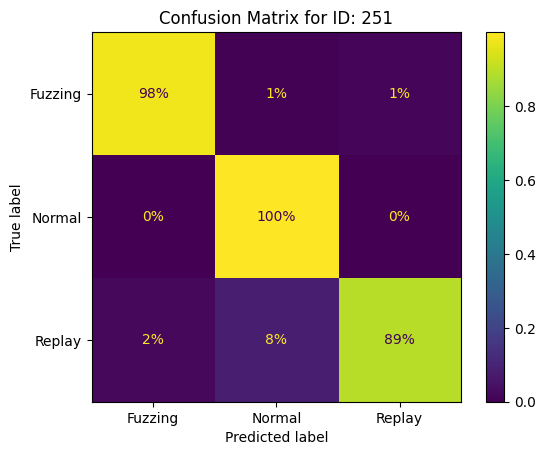

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.75      0.92      0.83      1076
      Normal       0.99      1.00      1.00     74723
      Replay       0.94      0.41      0.57      1576

    accuracy                           0.99     77375
   macro avg       0.89      0.78      0.80     77375
weighted avg       0.99      0.99      0.98     77375



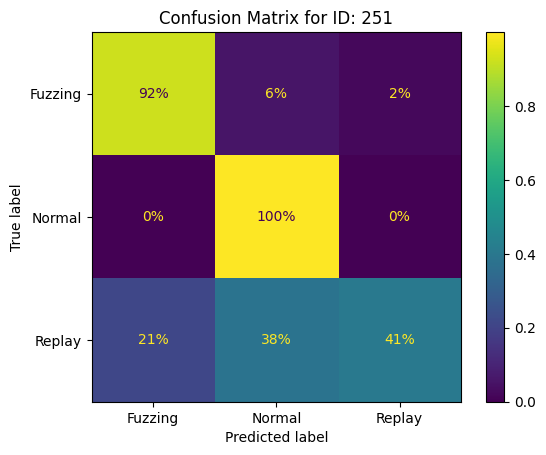

<Figure size 800x600 with 0 Axes>



Result 251 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          251  0.997402  0.982844  0.957603  0.969505
XGBoost                251  0.986611  0.894271  0.776035  0.796281


Processing ID: 2B0
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1043
      Normal       1.00      1.00      1.00     74696
      Replay       0.99      0.93      0.96      1576

    accuracy                           1.00     77315
   macro avg       1.00      0.98      0.99     77315
weighted avg       1.00      1.00      1.00     77315



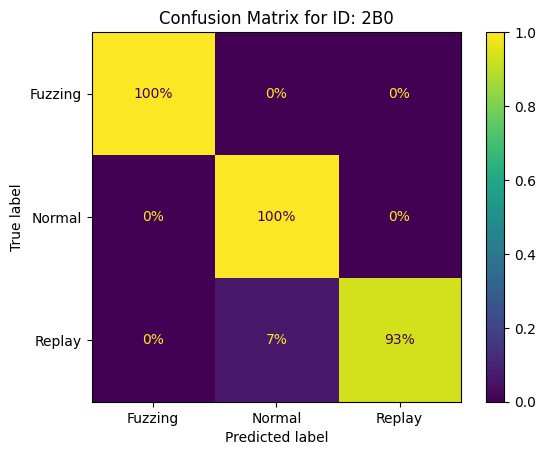

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1043
      Normal       0.99      1.00      0.99     74696
      Replay       0.98      0.53      0.69      1576

    accuracy                           0.99     77315
   macro avg       0.99      0.84      0.89     77315
weighted avg       0.99      0.99      0.99     77315



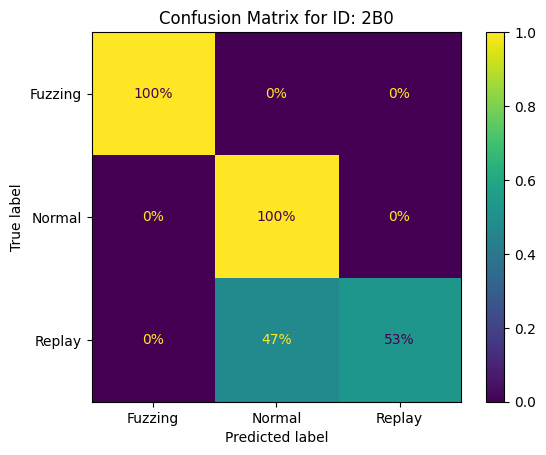

<Figure size 800x600 with 0 Axes>



Result 2B0 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          2B0  0.998435  0.995945   0.97772  0.986562
XGBoost                2B0   0.99017  0.991552  0.841947  0.893543


Processing ID: 381
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       523
      Normal       1.00      1.00      1.00     37344
      Replay       0.96      0.84      0.89       788

    accuracy                           1.00     38655
   macro avg       0.98      0.95      0.96     38655
weighted avg       1.00      1.00      1.00     38655



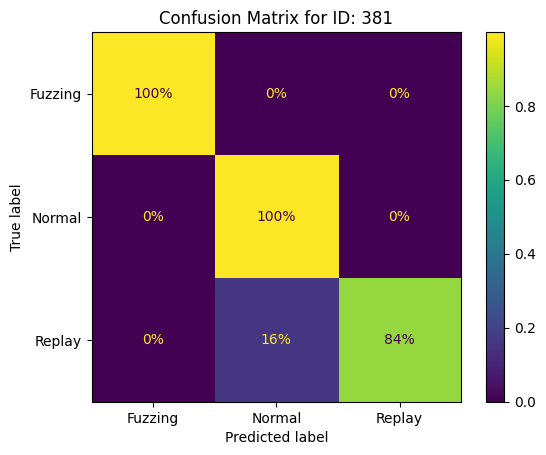

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.99      0.99       523
      Normal       0.99      1.00      0.99     37344
      Replay       0.87      0.44      0.59       788

    accuracy                           0.99     38655
   macro avg       0.95      0.81      0.86     38655
weighted avg       0.99      0.99      0.99     38655



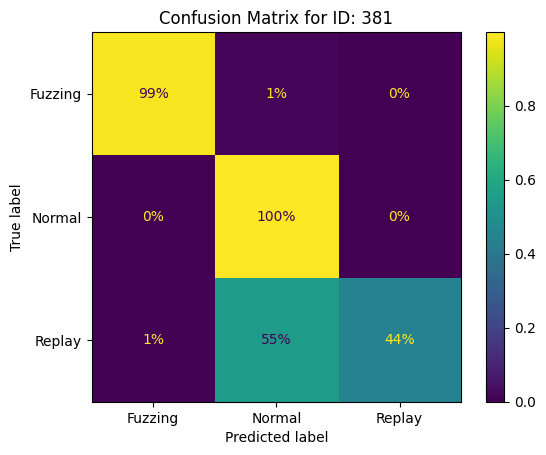

<Figure size 800x600 with 0 Axes>



Result 381 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          381  0.995964  0.983998  0.946218  0.963902
XGBoost                381  0.987065  0.949466   0.80894  0.856071


Processing ID: 340
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       506
      Normal       1.00      1.00      1.00     74679
      Replay       1.00      0.85      0.92      1575

    accuracy                           1.00     76760
   macro avg       1.00      0.95      0.97     76760
weighted avg       1.00      1.00      1.00     76760



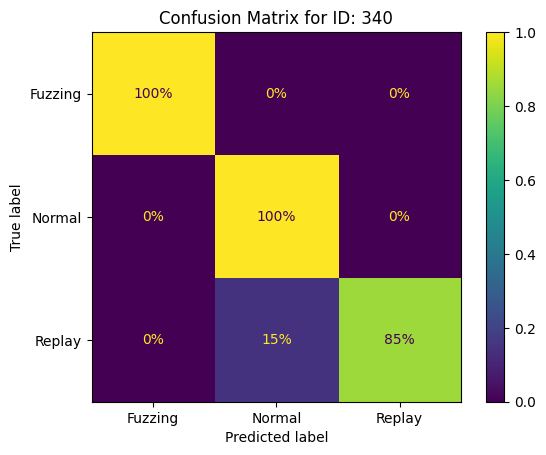

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       506
      Normal       0.99      1.00      0.99     74679
      Replay       0.99      0.47      0.64      1575

    accuracy                           0.99     76760
   macro avg       0.99      0.82      0.88     76760
weighted avg       0.99      0.99      0.99     76760



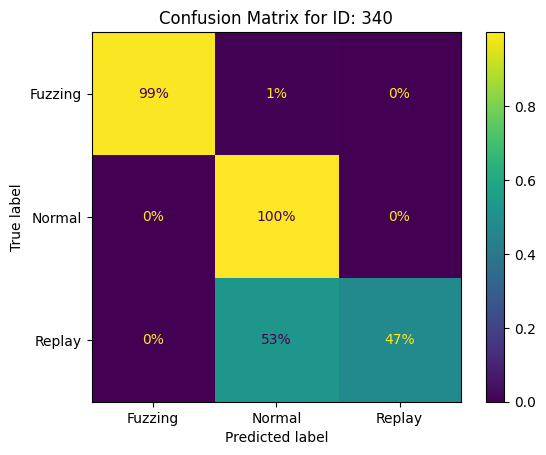

<Figure size 800x600 with 0 Axes>



Result 340 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          340  0.996899  0.997485  0.950873  0.972338
XGBoost                340  0.989122  0.994556  0.822768  0.877924


Processing ID: 260
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.67      1.00      0.80       970
      Normal       1.00      1.00      1.00     74673
      Replay       1.00      0.67      0.80      1577

    accuracy                           0.99     77220
   macro avg       0.89      0.89      0.87     77220
weighted avg       1.00      0.99      0.99     77220



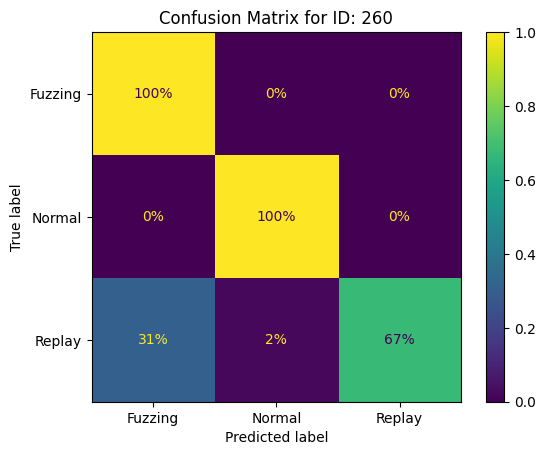

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       970
      Normal       1.00      1.00      1.00     74673
      Replay       1.00      1.00      1.00      1577

    accuracy                           1.00     77220
   macro avg       1.00      1.00      1.00     77220
weighted avg       1.00      1.00      1.00     77220



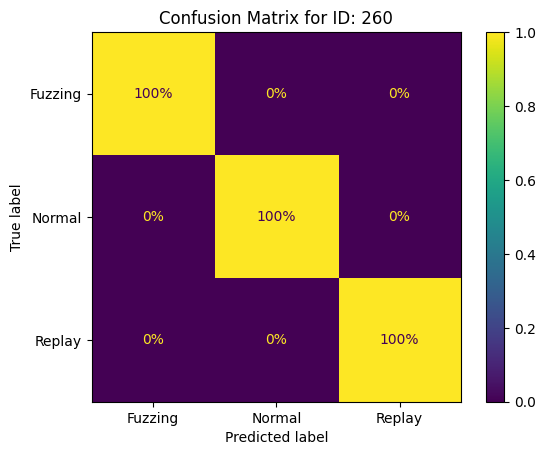

<Figure size 800x600 with 0 Axes>



Result 260 models:

              ProcessingID  Accuracy Precision    Recall F1 Score
Random Forest          260  0.993305  0.888746  0.890721  0.86791
XGBoost                260       1.0       1.0       1.0      1.0


Processing ID: 47F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       505
      Normal       0.99      1.00      1.00     37351
      Replay       1.00      0.63      0.77       788

    accuracy                           0.99     38644
   macro avg       1.00      0.88      0.92     38644
weighted avg       0.99      0.99      0.99     38644



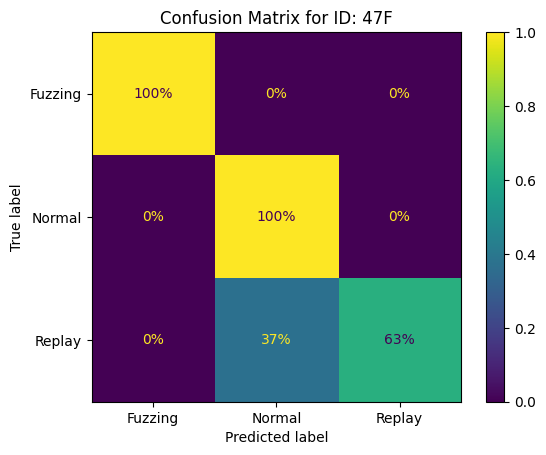

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       505
      Normal       0.99      1.00      0.99     37351
      Replay       1.00      0.48      0.65       788

    accuracy                           0.99     38644
   macro avg       1.00      0.83      0.88     38644
weighted avg       0.99      0.99      0.99     38644



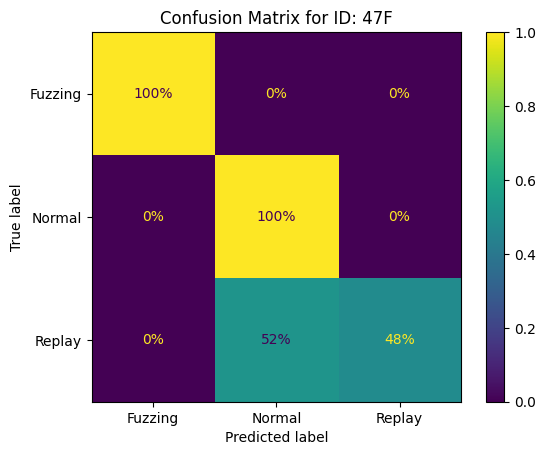

<Figure size 800x600 with 0 Axes>



Result 47F models:

              ProcessingID Accuracy Precision    Recall  F1 Score
Random Forest          47F  0.99247  0.997423  0.876904   0.92322
XGBoost                47F  0.98939  0.996381  0.826328  0.881026


Processing ID: 329
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       512
      Normal       0.99      1.00      0.99     74655
      Replay       1.00      0.39      0.56      1577

    accuracy                           0.99     76744
   macro avg       1.00      0.80      0.85     76744
weighted avg       0.99      0.99      0.98     76744



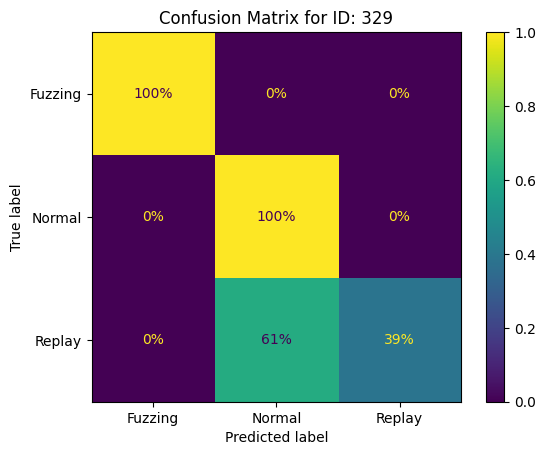

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       512
      Normal       0.99      1.00      0.99     74655
      Replay       1.00      0.42      0.59      1577

    accuracy                           0.99     76744
   macro avg       1.00      0.81      0.86     76744
weighted avg       0.99      0.99      0.99     76744



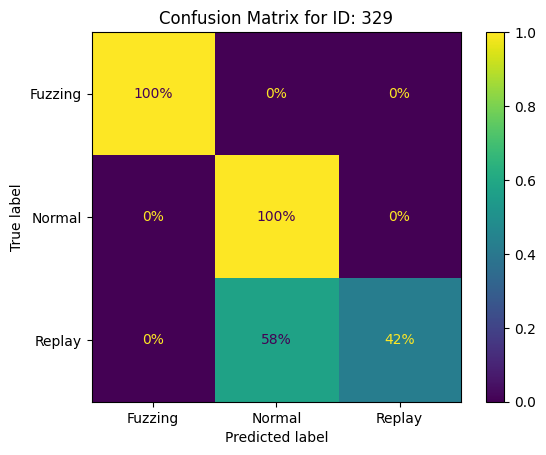

<Figure size 800x600 with 0 Axes>



Result 329 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          329  0.987387  0.995733  0.795392  0.850247
XGBoost                329  0.988129  0.995335  0.807001  0.862154


Processing ID: 164
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1023
      Normal       1.00      1.00      1.00     74700
      Replay       1.00      0.92      0.96      1576

    accuracy                           1.00     77299
   macro avg       1.00      0.97      0.99     77299
weighted avg       1.00      1.00      1.00     77299



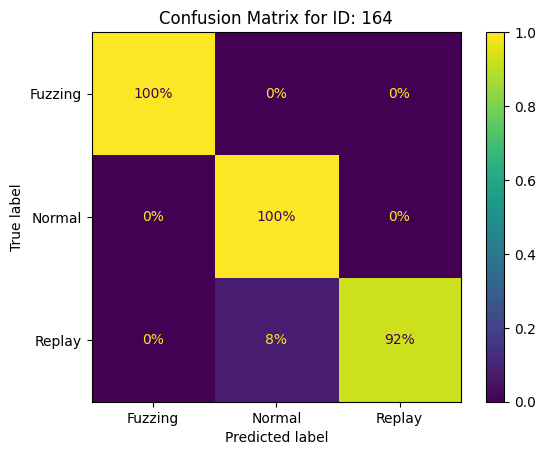

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1023
      Normal       0.99      1.00      1.00     74700
      Replay       1.00      0.71      0.83      1576

    accuracy                           0.99     77299
   macro avg       1.00      0.90      0.94     77299
weighted avg       0.99      0.99      0.99     77299



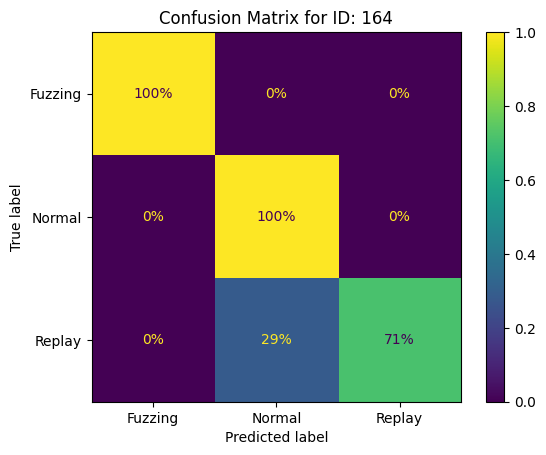

<Figure size 800x600 with 0 Axes>



Result 164 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          164  0.998422  0.999008   0.97461  0.986324
XGBoost                164  0.994114  0.997982  0.903765  0.942753


Processing ID: 387
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       512
      Normal       0.99      1.00      0.99     37300
      Replay       1.00      0.43      0.60       788

    accuracy                           0.99     38600
   macro avg       1.00      0.81      0.86     38600
weighted avg       0.99      0.99      0.99     38600



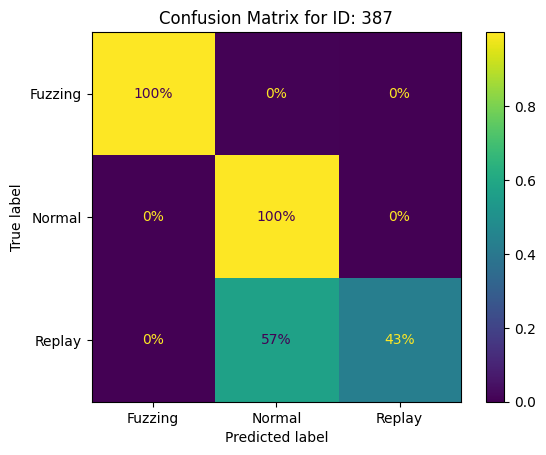

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       512
      Normal       0.99      1.00      0.99     37300
      Replay       0.97      0.34      0.50       788

    accuracy                           0.99     38600
   macro avg       0.99      0.77      0.83     38600
weighted avg       0.99      0.99      0.98     38600



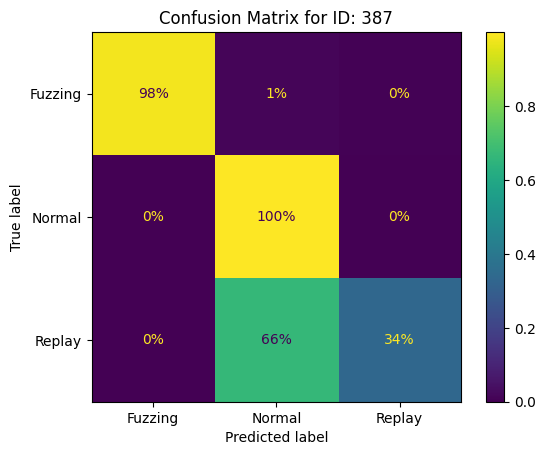

<Figure size 800x600 with 0 Axes>



Result 387 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          387  0.988264  0.995026  0.808334  0.863943
XGBoost                387  0.986036  0.985517  0.772429  0.827366


Processing ID: 394
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       452
      Normal       1.00      1.00      1.00     37319
      Replay       1.00      0.82      0.90       788

    accuracy                           1.00     38559
   macro avg       1.00      0.94      0.97     38559
weighted avg       1.00      1.00      1.00     38559



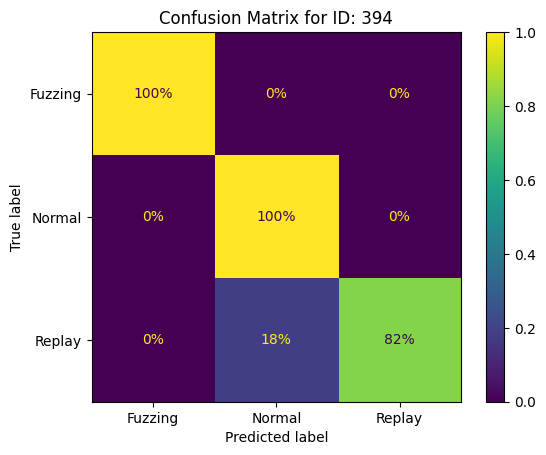

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       452
      Normal       0.99      1.00      1.00     37319
      Replay       1.00      0.55      0.71       788

    accuracy                           0.99     38559
   macro avg       1.00      0.85      0.90     38559
weighted avg       0.99      0.99      0.99     38559



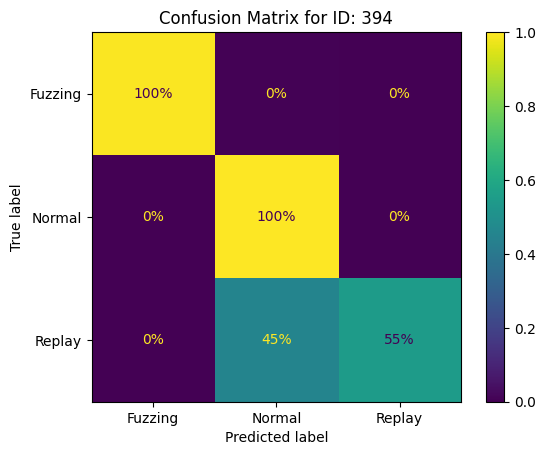

<Figure size 800x600 with 0 Axes>



Result 394 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          394   0.99624   0.99871  0.938663  0.965578
XGBoost                394  0.990716  0.996833  0.847933  0.900402


Processing ID: 4F1
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       482
      Normal       0.99      1.00      0.99     37293
      Replay       0.99      0.31      0.47       788

    accuracy                           0.99     38563
   macro avg       0.99      0.77      0.82     38563
weighted avg       0.99      0.99      0.98     38563



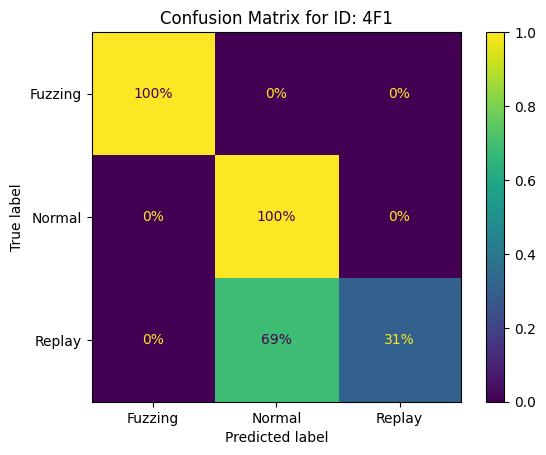

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       482
      Normal       0.99      1.00      0.99     37293
      Replay       0.94      0.31      0.47       788

    accuracy                           0.99     38563
   macro avg       0.98      0.77      0.82     38563
weighted avg       0.98      0.99      0.98     38563



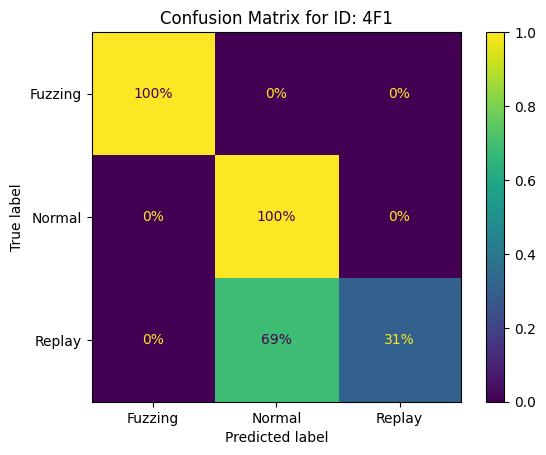

<Figure size 800x600 with 0 Axes>



Result 4F1 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          4F1  0.985841  0.992497  0.769864  0.821562
XGBoost                4F1  0.985504  0.975901  0.769747  0.819551


Processing ID: 130
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1028
      Normal       1.00      1.00      1.00     74657
      Replay       1.00      0.94      0.97      1575

    accuracy                           1.00     77260
   macro avg       1.00      0.98      0.99     77260
weighted avg       1.00      1.00      1.00     77260



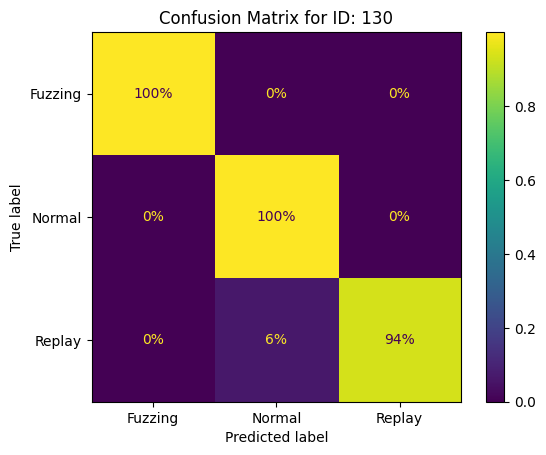

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.81      0.99      0.89      1028
      Normal       0.99      1.00      1.00     74657
      Replay       0.99      0.54      0.70      1575

    accuracy                           0.99     77260
   macro avg       0.93      0.84      0.86     77260
weighted avg       0.99      0.99      0.99     77260



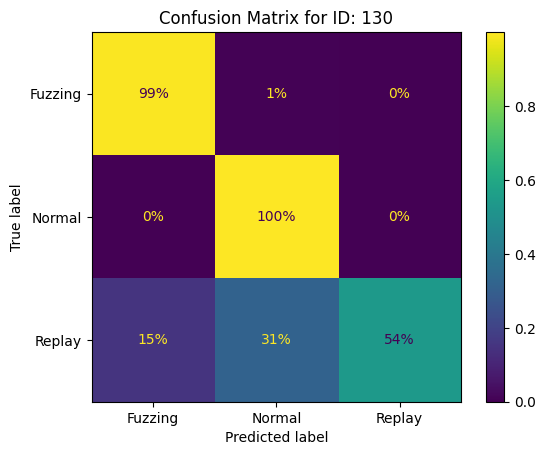

<Figure size 800x600 with 0 Axes>



Result 130 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          130  0.998693  0.999328  0.978719  0.988691
XGBoost                130   0.99037  0.931416  0.844143  0.862771


Processing ID: 140
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1004
      Normal       1.00      1.00      1.00     74648
      Replay       1.00      0.95      0.97      1575

    accuracy                           1.00     77227
   macro avg       1.00      0.98      0.99     77227
weighted avg       1.00      1.00      1.00     77227



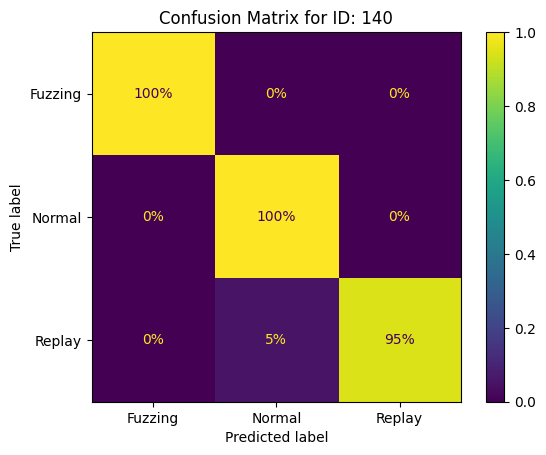

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00      1004
      Normal       1.00      1.00      1.00     74648
      Replay       1.00      0.80      0.89      1575

    accuracy                           1.00     77227
   macro avg       1.00      0.93      0.96     77227
weighted avg       1.00      1.00      1.00     77227



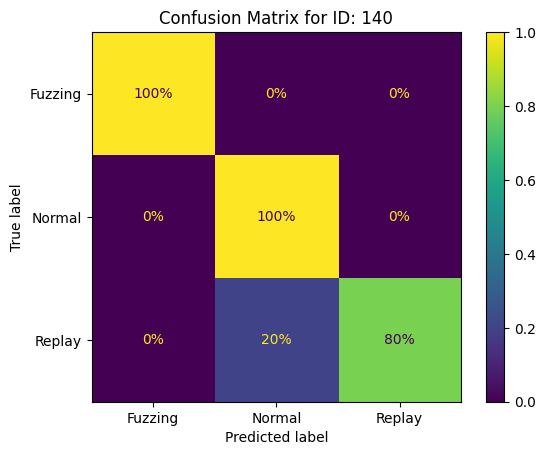

<Figure size 800x600 with 0 Axes>



Result 140 models:

              ProcessingID  Accuracy Precision   Recall  F1 Score
Random Forest          140  0.998873  0.998305  0.98283  0.990375
XGBoost                140  0.995895   0.99859  0.93279   0.96196


Processing ID: 356
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.43      0.39      0.41       526
      Normal       0.99      1.00      1.00     74749
      Replay       0.84      0.58      0.69      1576

    accuracy                           0.99     76851
   macro avg       0.75      0.66      0.70     76851
weighted avg       0.99      0.99      0.99     76851



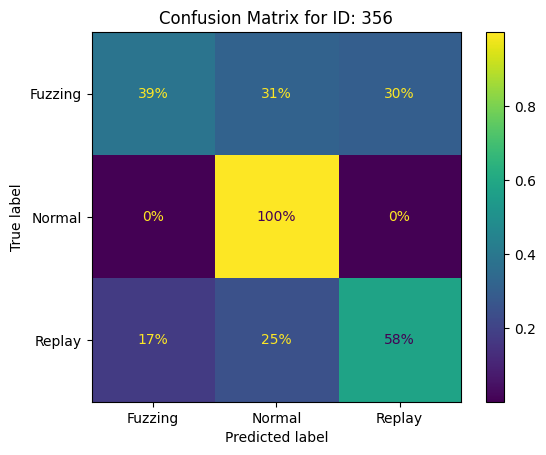

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.05      0.04      0.04       526
      Normal       0.99      1.00      0.99     74749
      Replay       0.86      0.42      0.56      1576

    accuracy                           0.98     76851
   macro avg       0.63      0.48      0.53     76851
weighted avg       0.98      0.98      0.98     76851



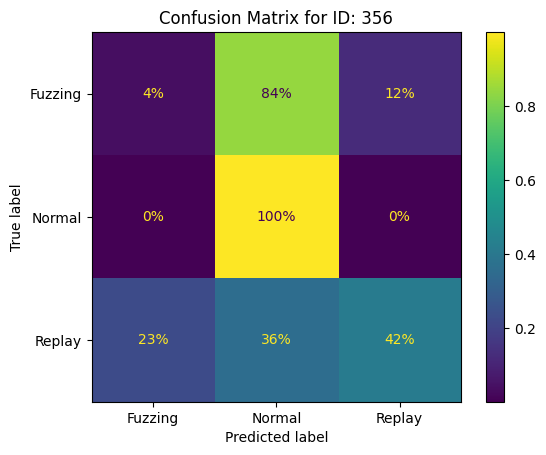

<Figure size 800x600 with 0 Axes>



Result 356 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          356  0.986975   0.75361  0.655222  0.696075
XGBoost                356  0.980664  0.630626  0.484273  0.531906


Processing ID: 153
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       980
      Normal       1.00      1.00      1.00     74658
      Replay       1.00      0.86      0.93      1576

    accuracy                           1.00     77214
   macro avg       1.00      0.95      0.97     77214
weighted avg       1.00      1.00      1.00     77214



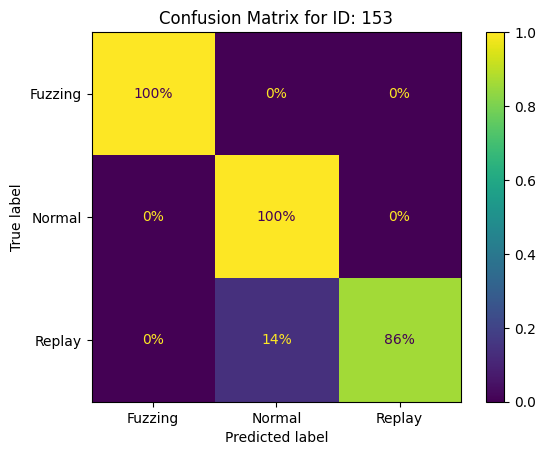

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       980
      Normal       1.00      1.00      1.00     74658
      Replay       1.00      0.91      0.95      1576

    accuracy                           1.00     77214
   macro avg       1.00      0.97      0.98     77214
weighted avg       1.00      1.00      1.00     77214



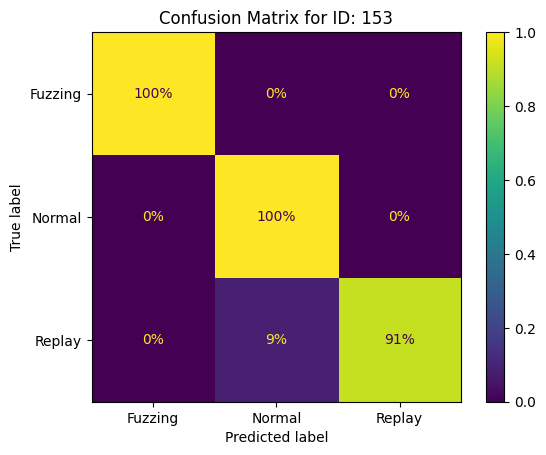

<Figure size 800x600 with 0 Axes>



Result 153 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          153  0.997203  0.999038  0.954315  0.974995
XGBoost                153    0.9982  0.999381  0.970601  0.984312


Processing ID: 220
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.99      0.99      1014
      Normal       1.00      1.00      1.00     74647
      Replay       1.00      0.82      0.90      1576

    accuracy                           1.00     77237
   macro avg       0.99      0.94      0.96     77237
weighted avg       1.00      1.00      1.00     77237



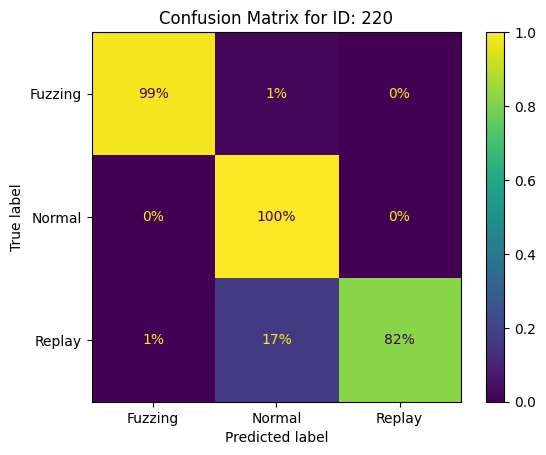

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99      1014
      Normal       0.99      1.00      0.99     74647
      Replay       1.00      0.31      0.48      1576

    accuracy                           0.99     77237
   macro avg       1.00      0.77      0.82     77237
weighted avg       0.99      0.99      0.98     77237



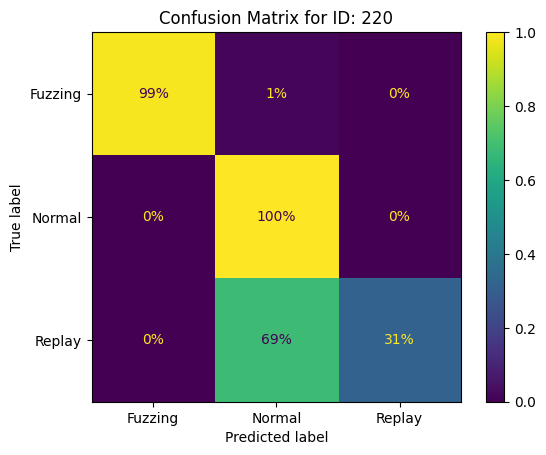

<Figure size 800x600 with 0 Axes>



Result 220 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          220  0.996168  0.994784  0.935753  0.962337
XGBoost                220  0.985836  0.995185  0.766971  0.821513


Processing ID: 367
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.98      0.95      0.97       503
      Normal       0.99      1.00      1.00     74684
      Replay       0.99      0.72      0.84      1584

    accuracy                           0.99     76771
   macro avg       0.99      0.89      0.93     76771
weighted avg       0.99      0.99      0.99     76771



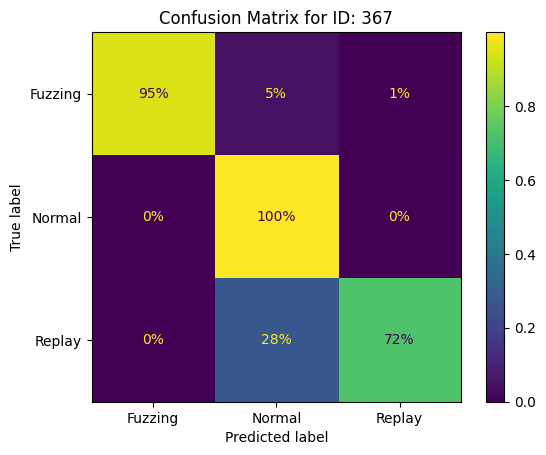

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.85      0.99      0.92       503
      Normal       0.99      1.00      0.99     74684
      Replay       0.87      0.43      0.58      1584

    accuracy                           0.99     76771
   macro avg       0.90      0.81      0.83     76771
weighted avg       0.98      0.99      0.98     76771



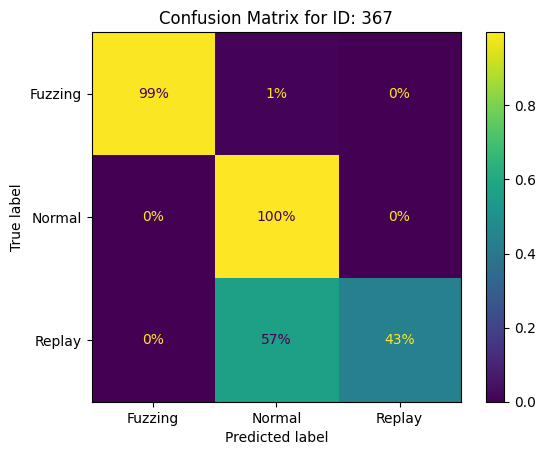

<Figure size 800x600 with 0 Axes>



Result 367 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          367  0.993735  0.989002  0.890522  0.932761
XGBoost                367  0.985828  0.904455  0.807094  0.829313


Processing ID: 368
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       466
      Normal       0.99      1.00      0.99     74657
      Replay       0.99      0.40      0.57      1577

    accuracy                           0.99     76700
   macro avg       0.99      0.80      0.86     76700
weighted avg       0.99      0.99      0.99     76700



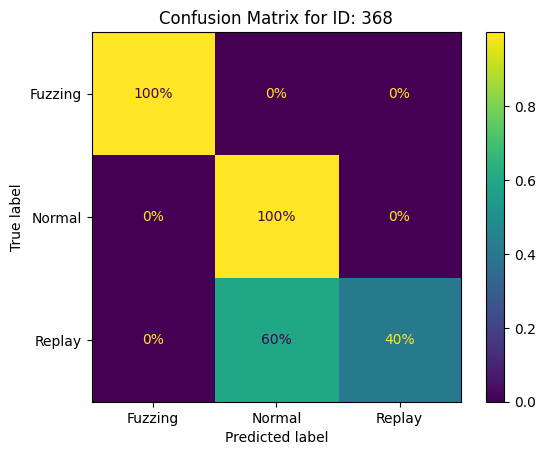

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       466
      Normal       0.99      1.00      0.99     74657
      Replay       0.99      0.37      0.54      1577

    accuracy                           0.99     76700
   macro avg       0.99      0.79      0.84     76700
weighted avg       0.99      0.99      0.98     76700



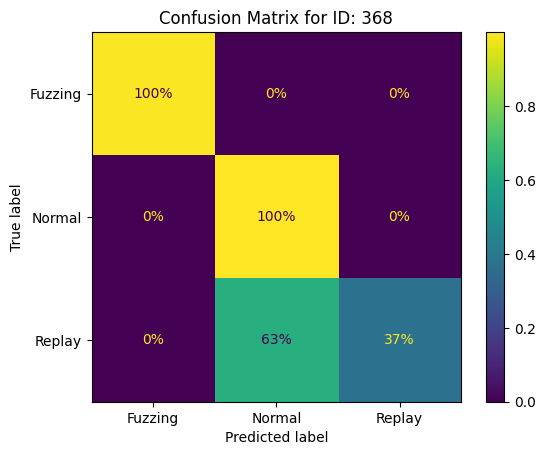

<Figure size 800x600 with 0 Axes>



Result 368 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          368  0.987627  0.992217  0.800353  0.855194
XGBoost                368  0.986988  0.991705  0.789285  0.843994


Processing ID: 412
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       511
      Normal       1.00      1.00      1.00      3730
      Replay       1.00      0.94      0.97        79

    accuracy                           1.00      4320
   macro avg       1.00      0.98      0.99      4320
weighted avg       1.00      1.00      1.00      4320



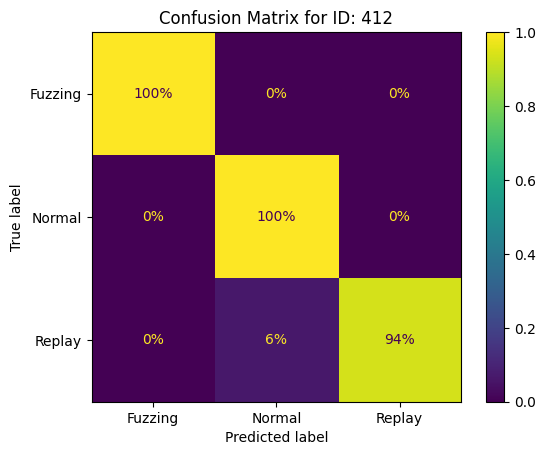

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       511
      Normal       1.00      1.00      1.00      3730
      Replay       0.99      0.95      0.97        79

    accuracy                           1.00      4320
   macro avg       1.00      0.98      0.99      4320
weighted avg       1.00      1.00      1.00      4320



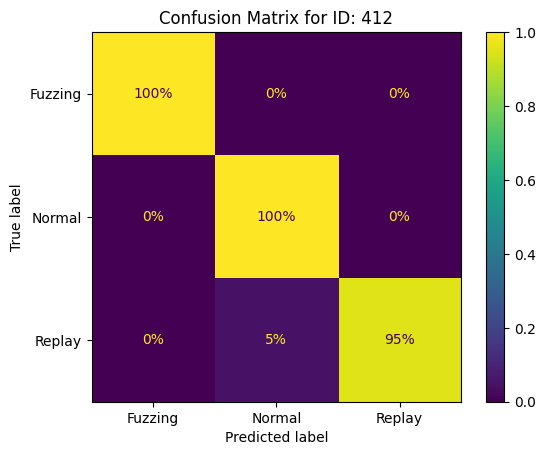

<Figure size 800x600 with 0 Axes>



Result 412 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          412  0.998843  0.999554  0.978903  0.988883
XGBoost                412  0.998843  0.995257  0.983033  0.989024


Processing ID: 470
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.98      0.90      0.94       511
      Normal       1.00      1.00      1.00     37225
      Replay       0.94      0.80      0.86       788

    accuracy                           0.99     38524
   macro avg       0.97      0.90      0.93     38524
weighted avg       0.99      0.99      0.99     38524



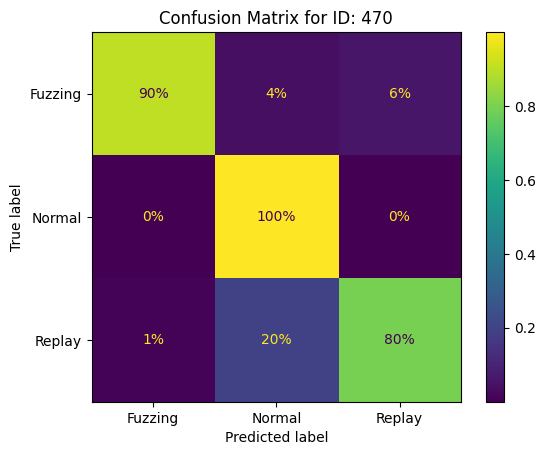

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.67      0.60      0.64       511
      Normal       0.99      1.00      1.00     37225
      Replay       0.81      0.64      0.72       788

    accuracy                           0.99     38524
   macro avg       0.83      0.75      0.78     38524
weighted avg       0.99      0.99      0.99     38524



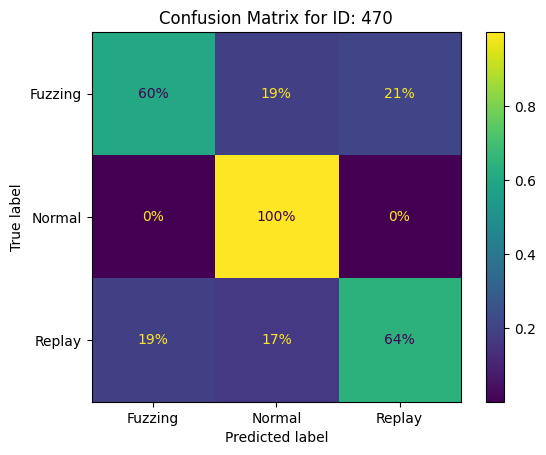

<Figure size 800x600 with 0 Axes>



Result 470 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          470  0.994159   0.97137  0.899154  0.932793
XGBoost                470  0.987125  0.825899  0.748835   0.78344


Processing ID: 38D
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       1.00      1.00      1.00     37328
      Replay       1.00      0.88      0.93       788

    accuracy                           1.00     38617
   macro avg       1.00      0.96      0.98     38617
weighted avg       1.00      1.00      1.00     38617



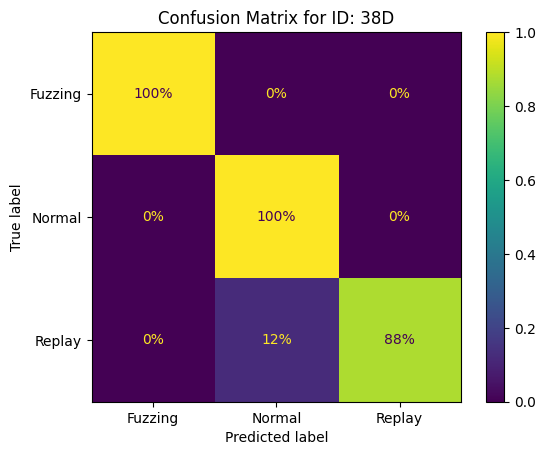

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       1.00      1.00      1.00     37328
      Replay       1.00      0.91      0.95       788

    accuracy                           1.00     38617
   macro avg       1.00      0.97      0.98     38617
weighted avg       1.00      1.00      1.00     38617



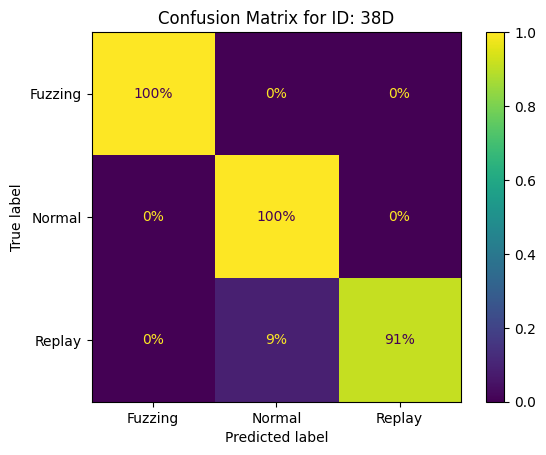

<Figure size 800x600 with 0 Axes>



Result 38D models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          38D  0.997488  0.998664  0.959382  0.977735
XGBoost                38D  0.998187  0.999376  0.970389  0.984194


Processing ID: 420
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       1.00      1.00      1.00     37301
      Replay       1.00      0.79      0.88       788

    accuracy                           1.00     38590
   macro avg       1.00      0.93      0.96     38590
weighted avg       1.00      1.00      1.00     38590



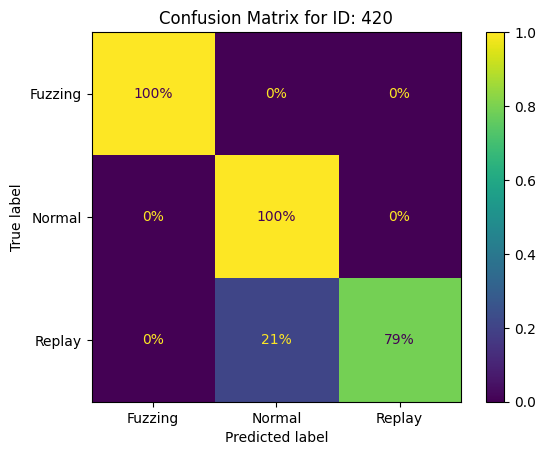

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       501
      Normal       0.99      1.00      1.00     37301
      Replay       1.00      0.68      0.81       788

    accuracy                           0.99     38590
   macro avg       1.00      0.89      0.94     38590
weighted avg       0.99      0.99      0.99     38590



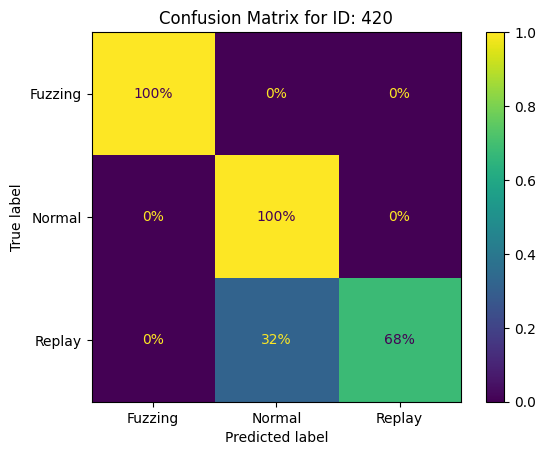

<Figure size 800x600 with 0 Axes>



Result 420 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          420  0.995647  0.997455  0.929762  0.959591
XGBoost                420  0.993444  0.997754  0.892736  0.935096


Processing ID: 421
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       499
      Normal       0.99      1.00      1.00     37282
      Replay       0.97      0.74      0.84       788

    accuracy                           0.99     38569
   macro avg       0.99      0.91      0.94     38569
weighted avg       0.99      0.99      0.99     38569



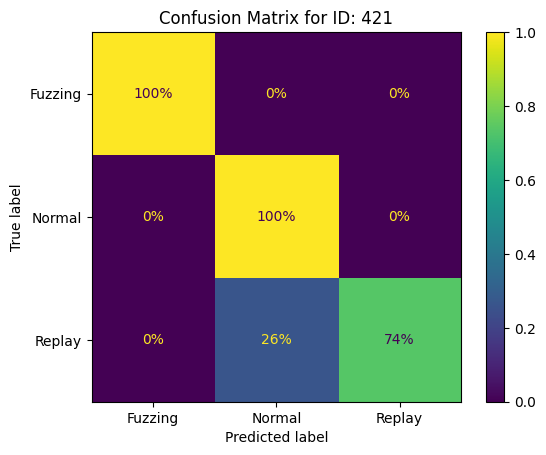

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       499
      Normal       0.99      1.00      1.00     37282
      Replay       0.98      0.65      0.78       788

    accuracy                           0.99     38569
   macro avg       0.99      0.88      0.93     38569
weighted avg       0.99      0.99      0.99     38569



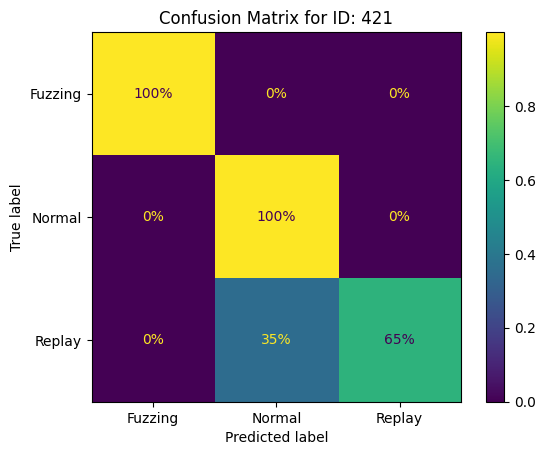

<Figure size 800x600 with 0 Axes>



Result 421 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          421  0.994166  0.988658  0.911862  0.944845
XGBoost                421  0.992533  0.992357   0.88124  0.925075


Processing ID: 389
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       493
      Normal       0.99      1.00      1.00     37272
      Replay       0.98      0.67      0.80       787

    accuracy                           0.99     38552
   macro avg       0.99      0.89      0.93     38552
weighted avg       0.99      0.99      0.99     38552



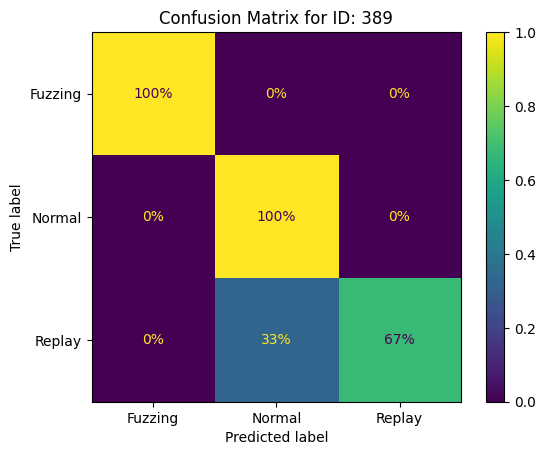

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       493
      Normal       0.99      1.00      1.00     37272
      Replay       0.95      0.58      0.72       787

    accuracy                           0.99     38552
   macro avg       0.98      0.86      0.91     38552
weighted avg       0.99      0.99      0.99     38552



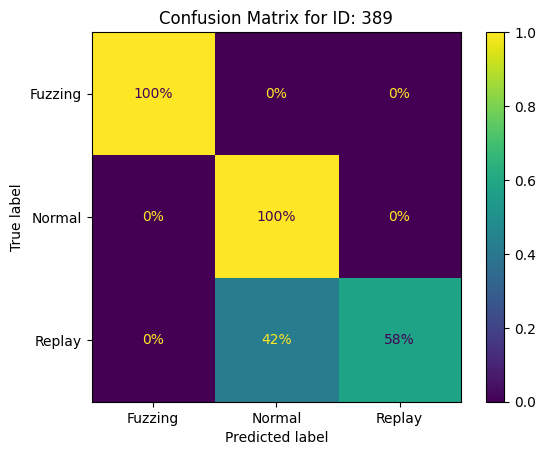

<Figure size 800x600 with 0 Axes>



Result 389 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          389  0.992996  0.989736  0.891032  0.931127
XGBoost                389  0.990844  0.981722  0.859608  0.905411


Processing ID: 386
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.76      1.00      0.86       505
      Normal       0.99      1.00      0.99     37314
      Replay       0.99      0.37      0.54       788

    accuracy                           0.98     38607
   macro avg       0.91      0.79      0.80     38607
weighted avg       0.98      0.98      0.98     38607



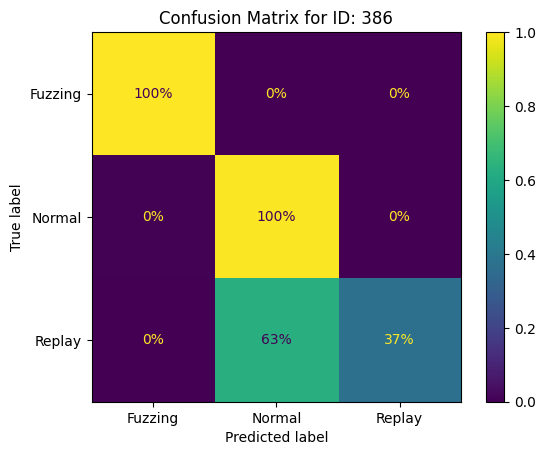

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.76      1.00      0.86       505
      Normal       0.99      0.99      0.99     37314
      Replay       0.78      0.32      0.46       788

    accuracy                           0.98     38607
   macro avg       0.84      0.77      0.77     38607
weighted avg       0.98      0.98      0.98     38607



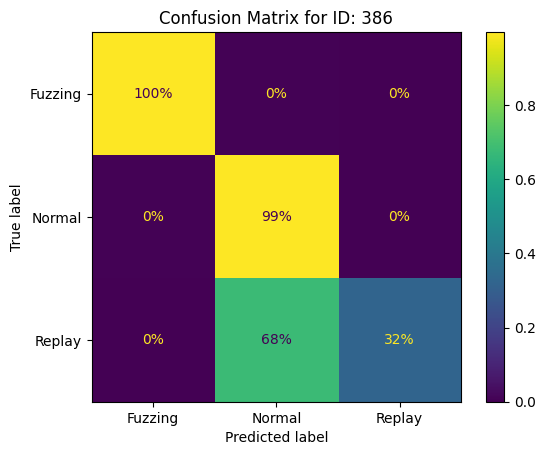

<Figure size 800x600 with 0 Axes>



Result 386 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          386  0.982931  0.912379  0.788316  0.797696
XGBoost                386  0.980185  0.843326  0.770332  0.769339


Processing ID: 492
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       442
      Normal       1.00      1.00      1.00     14929
      Replay       1.00      0.83      0.91       315

    accuracy                           1.00     15686
   macro avg       1.00      0.94      0.97     15686
weighted avg       1.00      1.00      1.00     15686



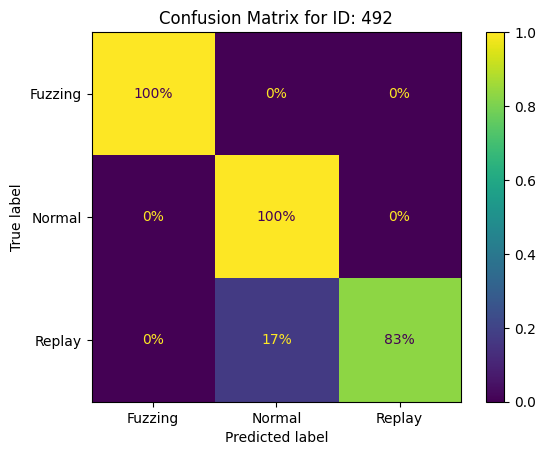

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       442
      Normal       0.99      1.00      1.00     14929
      Replay       0.98      0.73      0.84       315

    accuracy                           0.99     15686
   macro avg       0.99      0.91      0.94     15686
weighted avg       0.99      0.99      0.99     15686



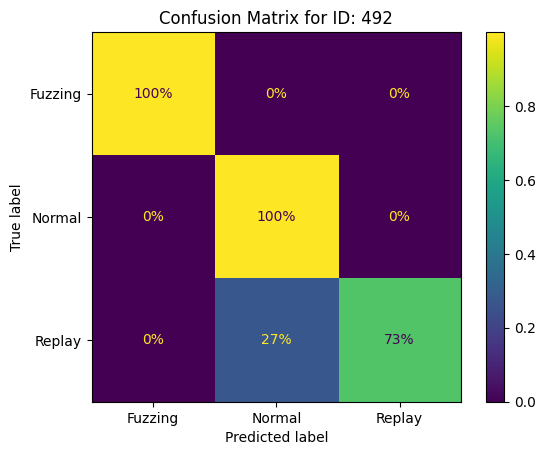

<Figure size 800x600 with 0 Axes>



Result 492 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          492  0.996557  0.998799  0.942857  0.968148
XGBoost                492  0.994199  0.990998  0.909187  0.944064


Processing ID: 391
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.91      0.95       513
      Normal       1.00      1.00      1.00     37341
      Replay       0.95      0.85      0.89       788

    accuracy                           1.00     38642
   macro avg       0.98      0.92      0.95     38642
weighted avg       1.00      1.00      1.00     38642



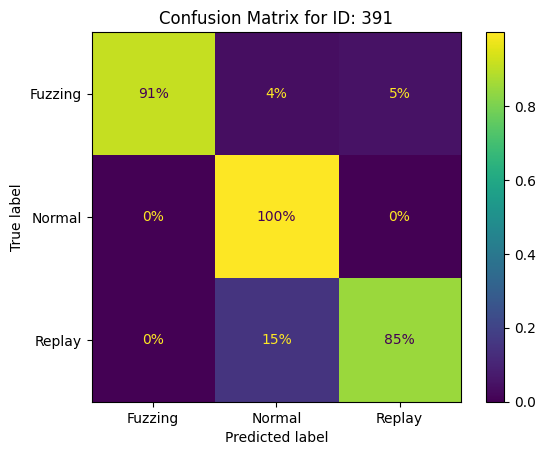

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.70      0.81      0.75       513
      Normal       0.99      1.00      1.00     37341
      Replay       0.89      0.61      0.72       788

    accuracy                           0.99     38642
   macro avg       0.86      0.80      0.82     38642
weighted avg       0.99      0.99      0.99     38642



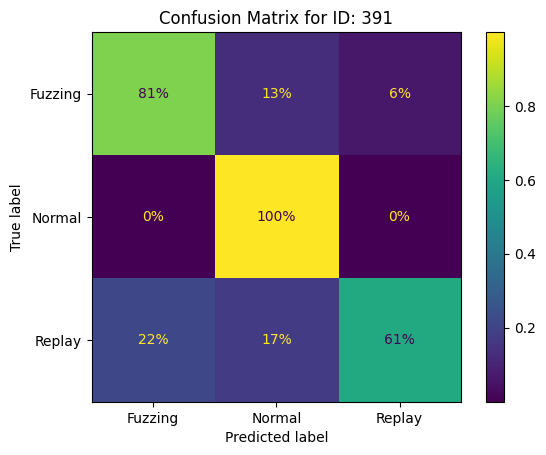

<Figure size 800x600 with 0 Axes>



Result 391 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          391  0.995394  0.980813  0.919242  0.948424
XGBoost                391  0.988691  0.862674  0.804062  0.823474


Processing ID: 485
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       473
      Normal       1.00      1.00      1.00     14907
      Replay       0.99      0.81      0.89       315

    accuracy                           1.00     15695
   macro avg       1.00      0.94      0.96     15695
weighted avg       1.00      1.00      1.00     15695



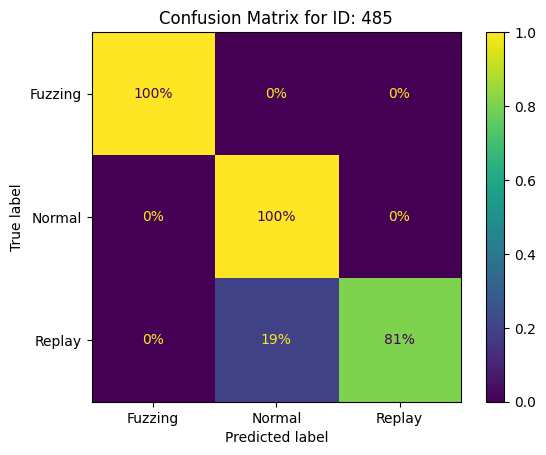

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       473
      Normal       1.00      1.00      1.00     14907
      Replay       1.00      0.87      0.93       315

    accuracy                           1.00     15695
   macro avg       1.00      0.96      0.98     15695
weighted avg       1.00      1.00      1.00     15695



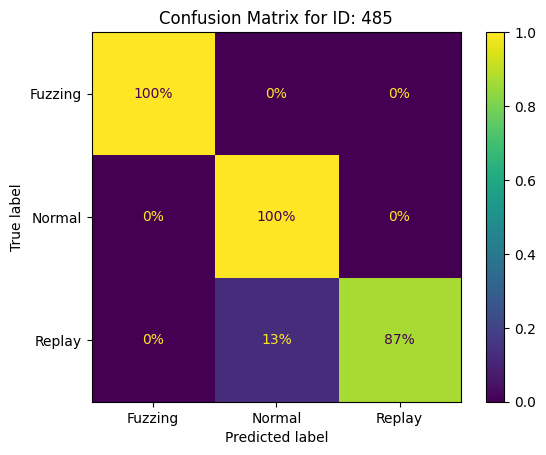

<Figure size 800x600 with 0 Axes>



Result 485 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          485  0.995986  0.996037  0.935405  0.962519
XGBoost                485  0.997388  0.999086  0.956614  0.976339


Processing ID: 490
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       1.00      1.00      1.00     14921
      Replay       0.98      0.86      0.92       315

    accuracy                           1.00     15733
   macro avg       0.99      0.95      0.97     15733
weighted avg       1.00      1.00      1.00     15733



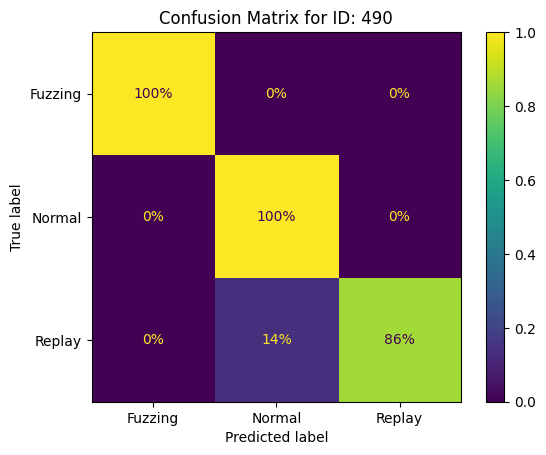

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       0.99      1.00      1.00     14921
      Replay       0.95      0.68      0.79       315

    accuracy                           0.99     15733
   macro avg       0.98      0.89      0.93     15733
weighted avg       0.99      0.99      0.99     15733



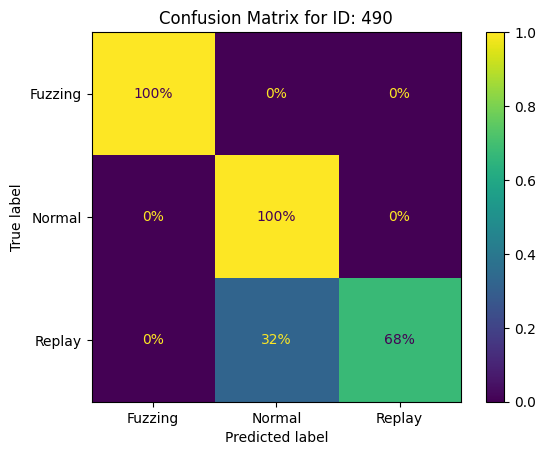

<Figure size 800x600 with 0 Axes>



Result 490 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          490  0.996886  0.992981  0.953327  0.971817
XGBoost                490  0.992754  0.979957  0.891795   0.92836


Processing ID: 593
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.13      1.00      0.23       485
      Normal       0.99      0.12      0.22      3733
      Replay       1.00      0.91      0.95        78

    accuracy                           0.24      4296
   macro avg       0.70      0.68      0.47      4296
weighted avg       0.89      0.24      0.23      4296



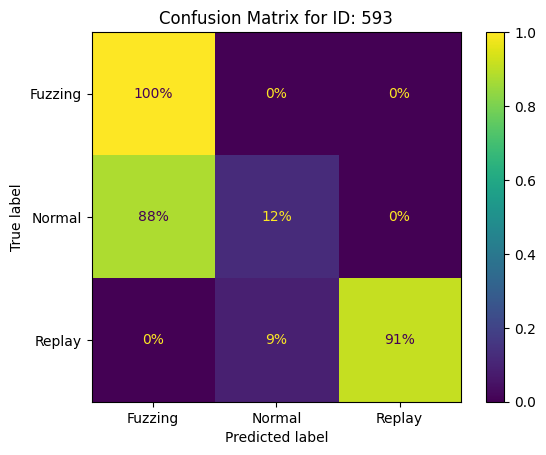

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       485
      Normal       1.00      1.00      1.00      3733
      Replay       0.93      0.95      0.94        78

    accuracy                           1.00      4296
   macro avg       0.97      0.98      0.98      4296
weighted avg       1.00      1.00      1.00      4296



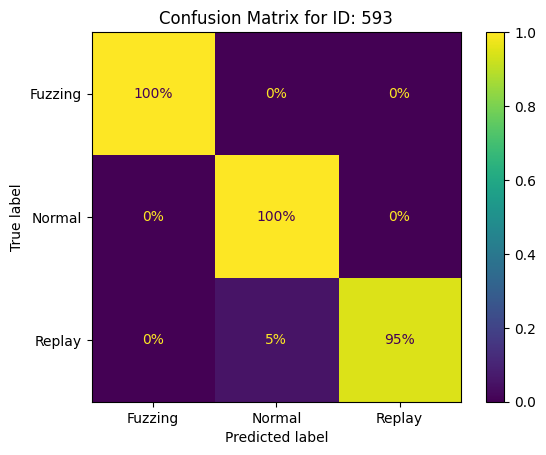

<Figure size 800x600 with 0 Axes>



Result 593 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          593   0.23743  0.704778  0.678184   0.46753
XGBoost                593  0.997672  0.974643   0.98237  0.978456


Processing ID: 484
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.88      1.00      0.93       492
      Normal       1.00      0.99      1.00     10649
      Replay       1.00      0.96      0.98       225

    accuracy                           0.99     11366
   macro avg       0.96      0.98      0.97     11366
weighted avg       0.99      0.99      0.99     11366



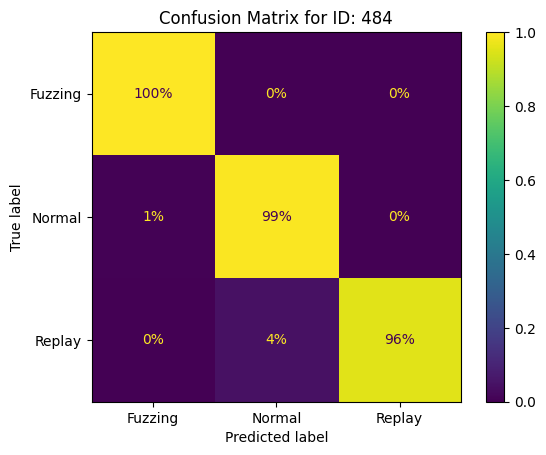

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.89      0.97      0.93       492
      Normal       1.00      0.99      1.00     10649
      Replay       1.00      0.96      0.98       225

    accuracy                           0.99     11366
   macro avg       0.96      0.98      0.97     11366
weighted avg       0.99      0.99      0.99     11366



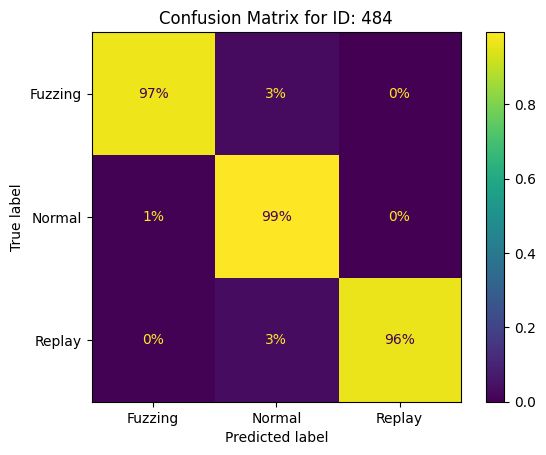

<Figure size 800x600 with 0 Axes>



Result 484 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          484  0.992961  0.958167  0.982994  0.969031
XGBoost                484  0.992873  0.962617   0.97617  0.968718


Processing ID: 48A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.96       496
      Normal       0.99      1.00      1.00     14924
      Replay       0.97      0.82      0.89       315

    accuracy                           0.99     15735
   macro avg       0.99      0.92      0.95     15735
weighted avg       0.99      0.99      0.99     15735



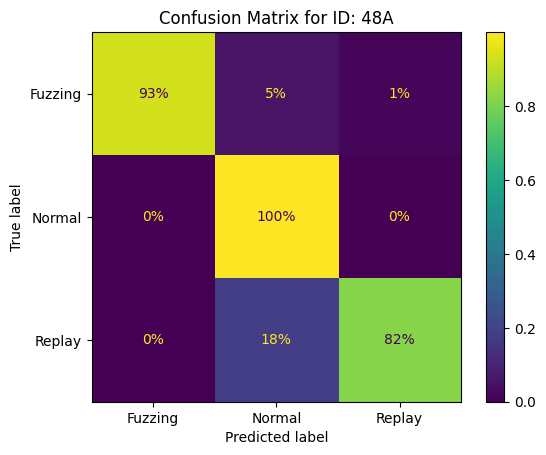

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.88      0.88      0.88       496
      Normal       0.99      1.00      0.99     14924
      Replay       0.98      0.49      0.65       315

    accuracy                           0.99     15735
   macro avg       0.95      0.79      0.84     15735
weighted avg       0.99      0.99      0.98     15735



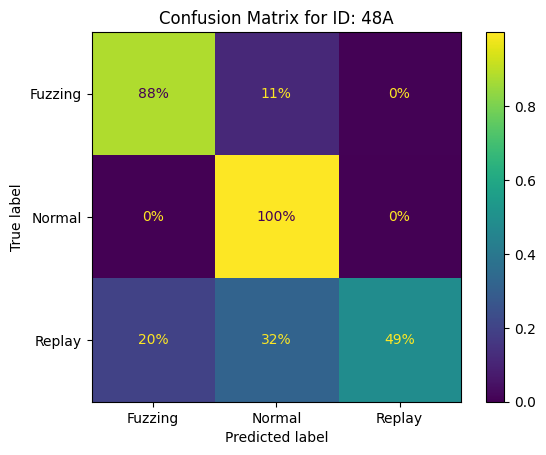

<Figure size 800x600 with 0 Axes>



Result 48A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          48A  0.994153  0.988109  0.916811  0.949931
XGBoost                48A  0.985891  0.948703  0.788899  0.840936


Processing ID: 50C
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       496
      Normal       1.00      1.00      1.00      7452
      Replay       1.00      1.00      1.00       158

    accuracy                           1.00      8106
   macro avg       1.00      1.00      1.00      8106
weighted avg       1.00      1.00      1.00      8106



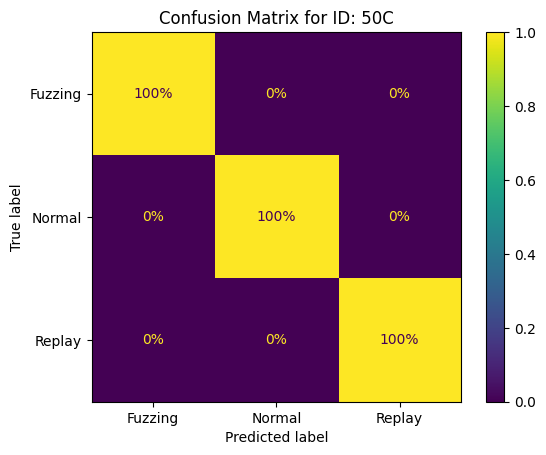

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       496
      Normal       1.00      1.00      1.00      7452
      Replay       1.00      1.00      1.00       158

    accuracy                           1.00      8106
   macro avg       1.00      1.00      1.00      8106
weighted avg       1.00      1.00      1.00      8106



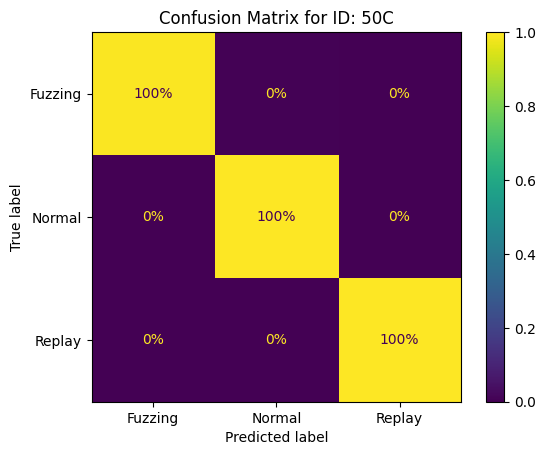

<Figure size 800x600 with 0 Axes>



Result 50C models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          50C       1.0       1.0       1.0       1.0
XGBoost                50C  0.999753  0.999911  0.998656  0.999282


Processing ID: 58B
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       530
      Normal       1.00      1.00      1.00     14920
      Replay       1.00      0.78      0.88       315

    accuracy                           1.00     15765
   macro avg       1.00      0.93      0.96     15765
weighted avg       1.00      1.00      1.00     15765



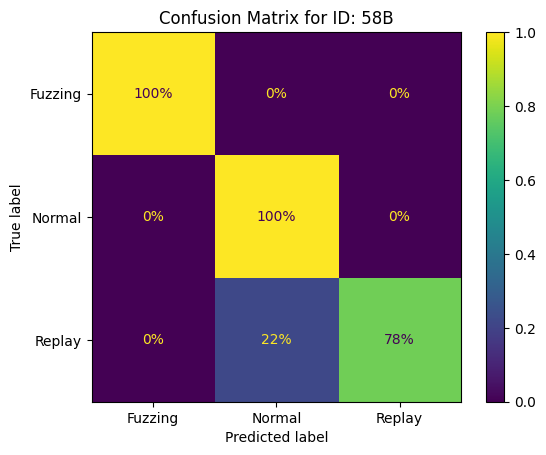

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       530
      Normal       0.99      1.00      1.00     14920
      Replay       0.98      0.65      0.78       315

    accuracy                           0.99     15765
   macro avg       0.99      0.88      0.92     15765
weighted avg       0.99      0.99      0.99     15765



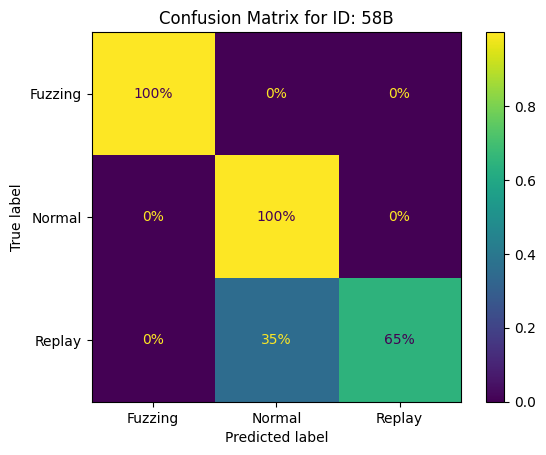

<Figure size 800x600 with 0 Axes>



Result 58B models:

              ProcessingID  Accuracy Precision   Recall  F1 Score
Random Forest          58B  0.995623  0.997143  0.92802  0.958378
XGBoost                58B  0.992515  0.989519  0.88117  0.924265


Processing ID: 436
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       503
      Normal       1.00      1.00      1.00     14916
      Replay       1.00      0.84      0.91       316

    accuracy                           1.00     15735
   macro avg       1.00      0.95      0.97     15735
weighted avg       1.00      1.00      1.00     15735



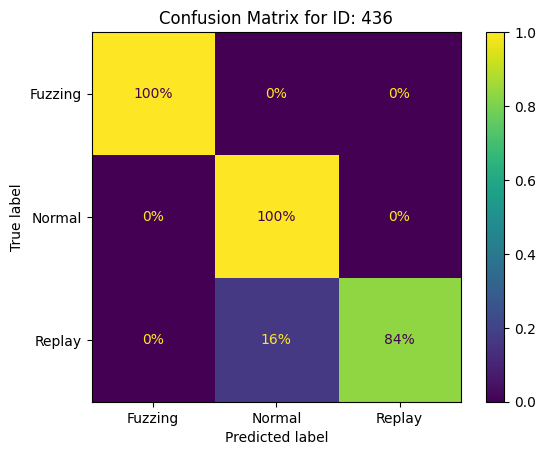

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       503
      Normal       0.99      1.00      1.00     14916
      Replay       0.95      0.71      0.82       316

    accuracy                           0.99     15735
   macro avg       0.98      0.90      0.94     15735
weighted avg       0.99      0.99      0.99     15735



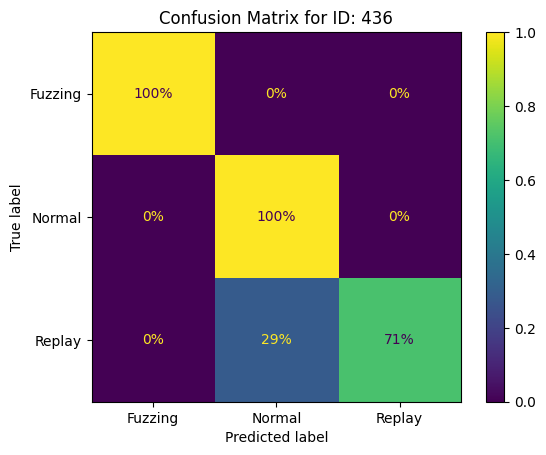

<Figure size 800x600 with 0 Axes>



Result 436 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          436  0.996695  0.998842  0.945148  0.969535
XGBoost                436  0.993518  0.982441  0.903763  0.937269


Processing ID: 541
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       521
      Normal       0.98      1.00      0.99      7924
      Replay       1.00      0.00      0.00       158

    accuracy                           0.98      8603
   macro avg       0.99      0.67      0.66      8603
weighted avg       0.98      0.98      0.97      8603



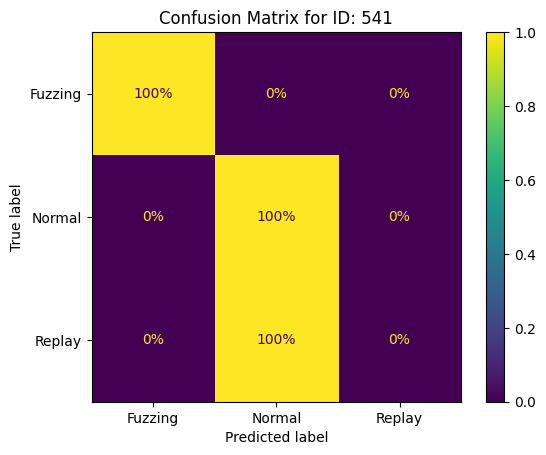

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       521
      Normal       0.99      1.00      1.00      7924
      Replay       0.93      0.72      0.81       158

    accuracy                           0.99      8603
   macro avg       0.98      0.91      0.94      8603
weighted avg       0.99      0.99      0.99      8603



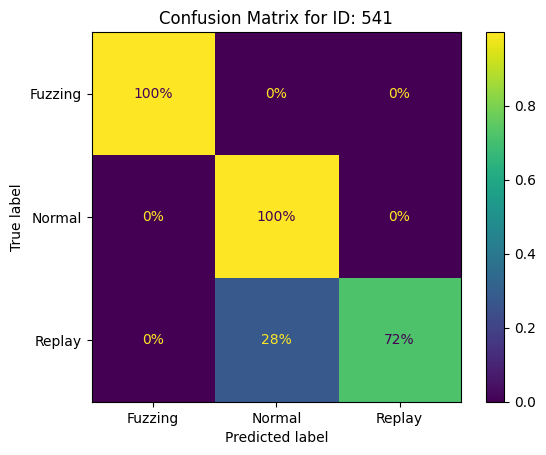

<Figure size 800x600 with 0 Axes>



Result 541 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          541  0.981634  0.993483  0.666667  0.663376
XGBoost                541  0.993956    0.9763  0.906239  0.936705


Processing ID: 507
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       514
      Normal       1.00      1.00      1.00      7457
      Replay       1.00      0.92      0.96       158

    accuracy                           1.00      8129
   macro avg       1.00      0.97      0.99      8129
weighted avg       1.00      1.00      1.00      8129



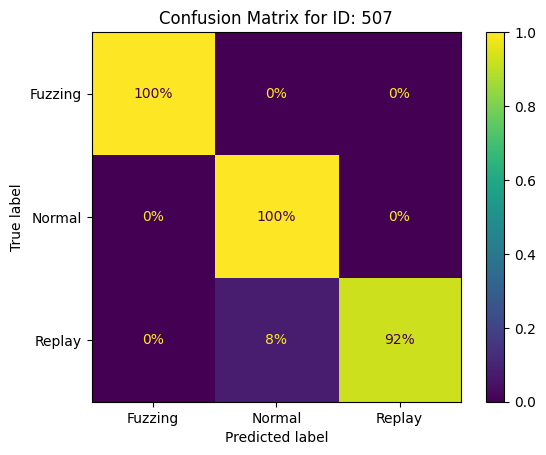

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       514
      Normal       1.00      1.00      1.00      7457
      Replay       1.00      0.94      0.97       158

    accuracy                           1.00      8129
   macro avg       1.00      0.98      0.99      8129
weighted avg       1.00      1.00      1.00      8129



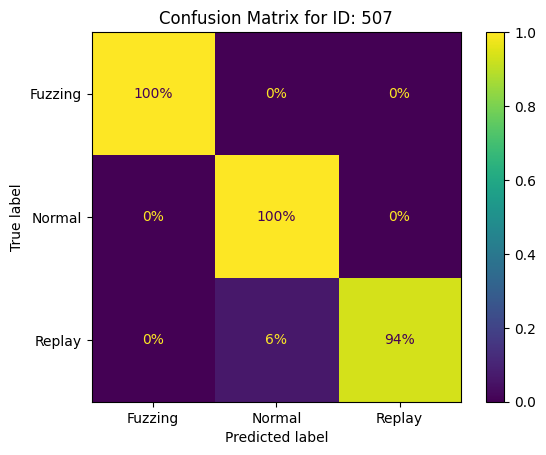

<Figure size 800x600 with 0 Axes>



Result 507 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          507  0.998524  0.999464  0.974684  0.986574
XGBoost                507   0.99877  0.999554  0.978903  0.988883


Processing ID: 4A7
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       484
      Normal       1.00      1.00      1.00      1492
      Replay       0.97      0.88      0.92        32

    accuracy                           1.00      2008
   macro avg       0.99      0.96      0.97      2008
weighted avg       1.00      1.00      1.00      2008



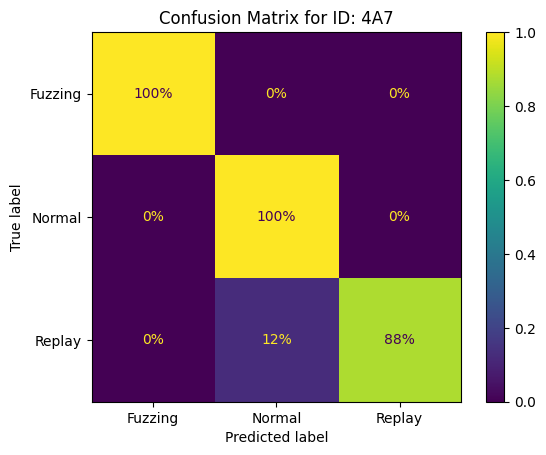

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       484
      Normal       1.00      1.00      1.00      1492
      Replay       1.00      0.91      0.95        32

    accuracy                           1.00      2008
   macro avg       1.00      0.97      0.98      2008
weighted avg       1.00      1.00      1.00      2008



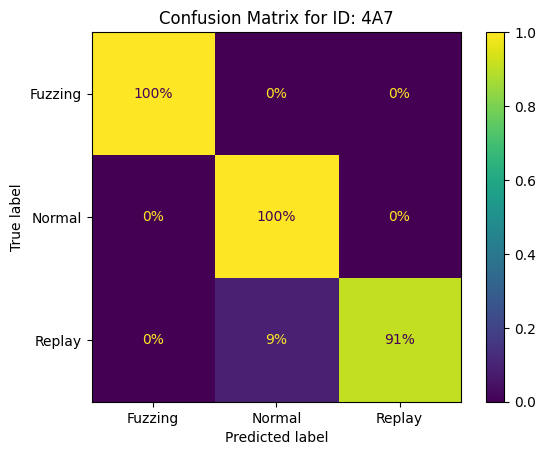

<Figure size 800x600 with 0 Axes>



Result 4A7 models:

              ProcessingID  Accuracy Precision   Recall  F1 Score
Random Forest          4A7   0.99751  0.987614  0.95811   0.97212
XGBoost                4A7  0.998506  0.999331  0.96875  0.983272


Processing ID: 520
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       502
      Normal       1.00      1.00      1.00      7433
      Replay       1.00      0.77      0.87       158

    accuracy                           1.00      8093
   macro avg       1.00      0.92      0.96      8093
weighted avg       1.00      1.00      1.00      8093



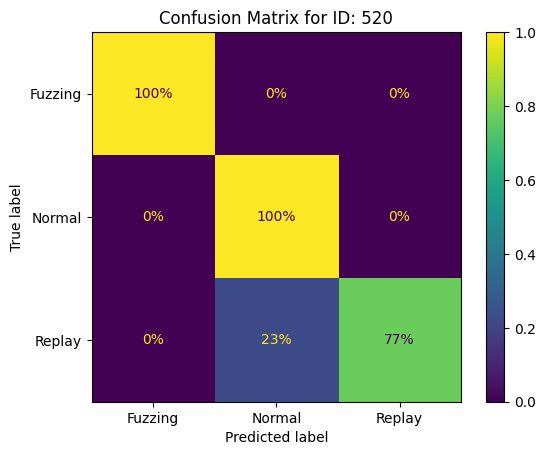

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       502
      Normal       1.00      1.00      1.00      7433
      Replay       0.99      0.86      0.92       158

    accuracy                           1.00      8093
   macro avg       1.00      0.95      0.97      8093
weighted avg       1.00      1.00      1.00      8093



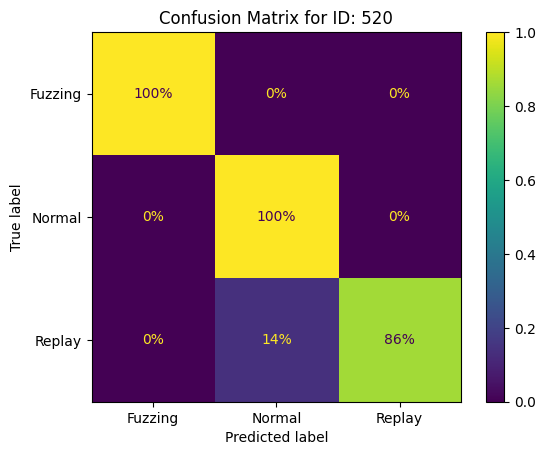

<Figure size 800x600 with 0 Axes>



Result 520 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          520  0.995552  0.998393  0.924051  0.956338
XGBoost                520  0.997158  0.996583  0.953542  0.973496


Processing ID: 53E
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       510
      Normal       1.00      1.00      1.00      7458
      Replay       0.99      0.92      0.95       157

    accuracy                           1.00      8125
   macro avg       0.99      0.97      0.98      8125
weighted avg       1.00      1.00      1.00      8125



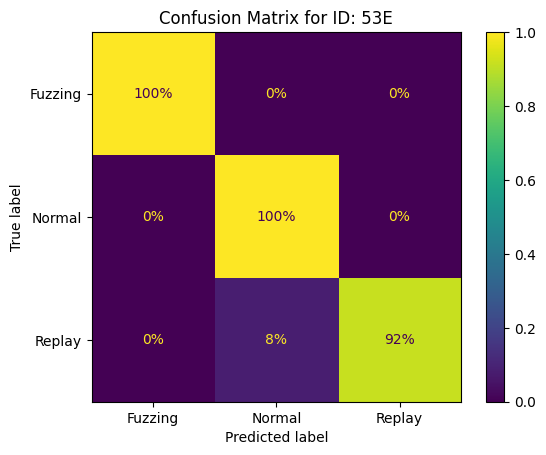

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       510
      Normal       1.00      1.00      1.00      7458
      Replay       0.99      0.95      0.97       157

    accuracy                           1.00      8125
   macro avg       1.00      0.98      0.99      8125
weighted avg       1.00      1.00      1.00      8125



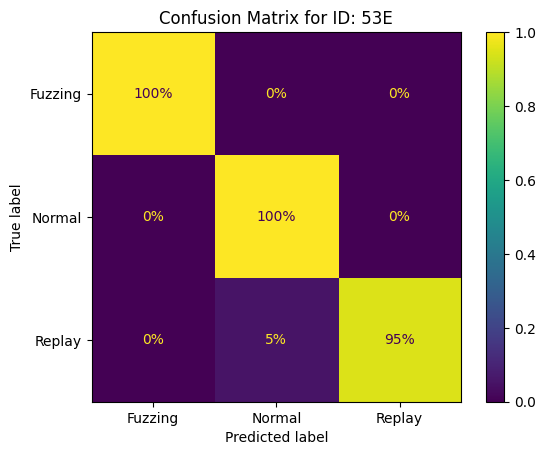

<Figure size 800x600 with 0 Axes>



Result 53E models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          53E  0.998154  0.994854   0.97231  0.983163
XGBoost                53E  0.998769  0.995228  0.982925  0.988954


Processing ID: 495
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.99      0.99       465
      Normal       1.00      1.00      1.00      7455
      Replay       0.99      0.89      0.94       157

    accuracy                           1.00      8077
   macro avg       0.99      0.96      0.98      8077
weighted avg       1.00      1.00      1.00      8077



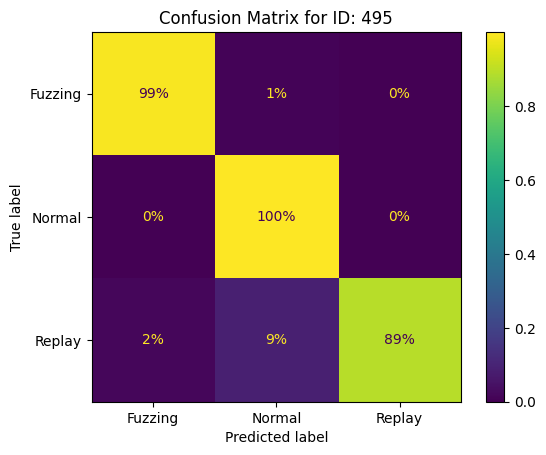

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.91      0.94      0.92       465
      Normal       1.00      1.00      1.00      7455
      Replay       0.85      0.67      0.75       157

    accuracy                           0.99      8077
   macro avg       0.92      0.87      0.89      8077
weighted avg       0.99      0.99      0.99      8077



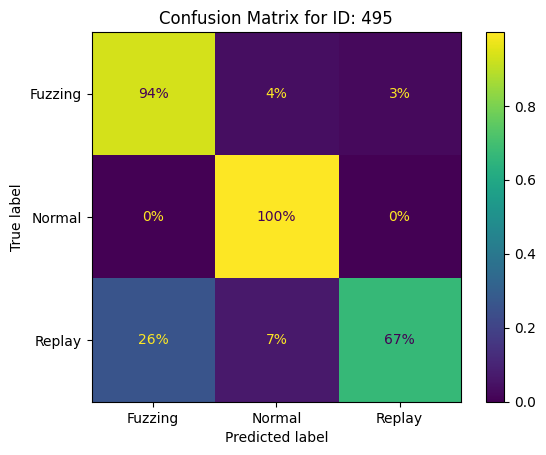

<Figure size 800x600 with 0 Axes>



Result 495 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          495  0.997276  0.994678  0.960994   0.97693
XGBoost                495  0.989105  0.921215  0.867823  0.890735


Processing ID: 500
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       533
      Normal       0.99      1.00      1.00      7445
      Replay       0.99      0.87      0.93       157

    accuracy                           0.99      8135
   macro avg       0.99      0.94      0.97      8135
weighted avg       0.99      0.99      0.99      8135



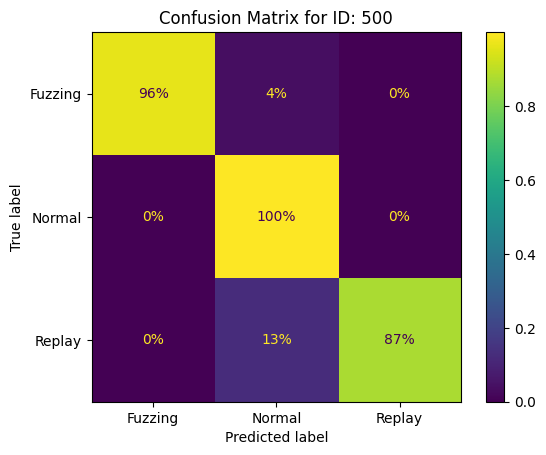

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.97      0.96      0.97       533
      Normal       0.99      1.00      1.00      7445
      Replay       0.97      0.76      0.85       157

    accuracy                           0.99      8135
   macro avg       0.98      0.91      0.94      8135
weighted avg       0.99      0.99      0.99      8135



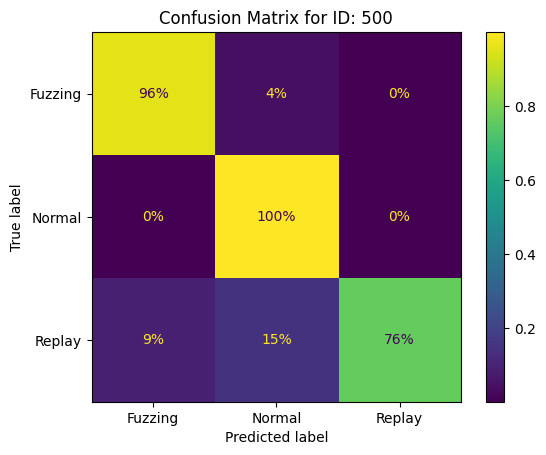

<Figure size 800x600 with 0 Axes>



Result 500 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          500   0.99496  0.993467  0.944985  0.967959
XGBoost                500  0.992256  0.977782  0.907506  0.938646


Processing ID: 483
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.92      0.96       504
      Normal       0.99      1.00      0.99      3749
      Replay       0.96      0.96      0.96        79

    accuracy                           0.99      4332
   macro avg       0.98      0.96      0.97      4332
weighted avg       0.99      0.99      0.99      4332



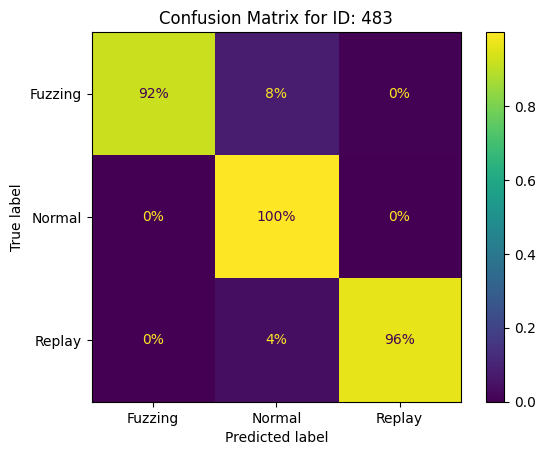

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       504
      Normal       1.00      1.00      1.00      3749
      Replay       0.95      1.00      0.98        79

    accuracy                           1.00      4332
   macro avg       0.98      0.99      0.98      4332
weighted avg       1.00      1.00      1.00      4332



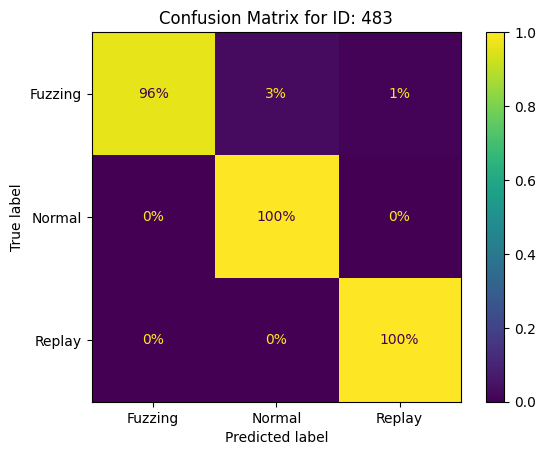

<Figure size 800x600 with 0 Axes>



Result 483 models:

              ProcessingID  Accuracy Precision    Recall F1 Score
Random Forest          483  0.989843  0.983735  0.960798  0.97171
XGBoost                483  0.995614  0.982607  0.987434   0.9847


Processing ID: 4A2
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       513
      Normal       1.00      1.00      1.00      1488
      Replay       0.90      0.88      0.89        32

    accuracy                           1.00      2033
   macro avg       0.97      0.96      0.96      2033
weighted avg       1.00      1.00      1.00      2033



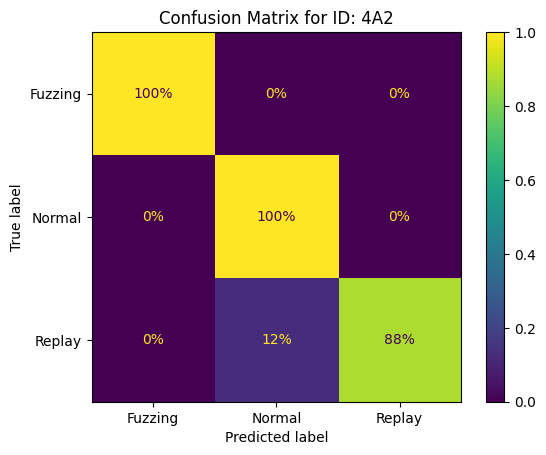

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       513
      Normal       1.00      1.00      1.00      1488
      Replay       0.85      0.91      0.88        32

    accuracy                           1.00      2033
   macro avg       0.95      0.97      0.96      2033
weighted avg       1.00      1.00      1.00      2033



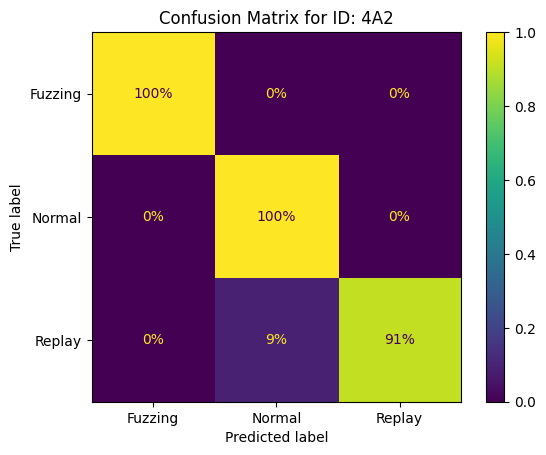

<Figure size 800x600 with 0 Axes>



Result 4A2 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          4A2  0.996557  0.966846  0.957661  0.962179
XGBoost                4A2  0.996065  0.950307   0.96763  0.958699


Processing ID: 50A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       515
      Normal       0.98      1.00      0.99      4906
      Replay       0.07      0.01      0.02        79

    accuracy                           0.98      5500
   macro avg       0.68      0.67      0.67      5500
weighted avg       0.97      0.98      0.98      5500



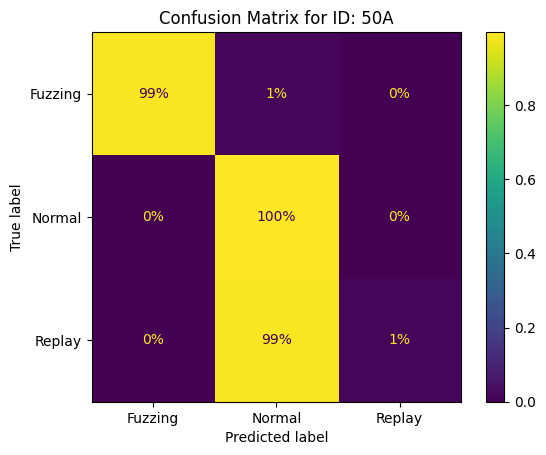

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       515
      Normal       0.99      1.00      0.99      4906
      Replay       0.71      0.41      0.52        79

    accuracy                           0.99      5500
   macro avg       0.90      0.79      0.83      5500
weighted avg       0.99      0.99      0.99      5500



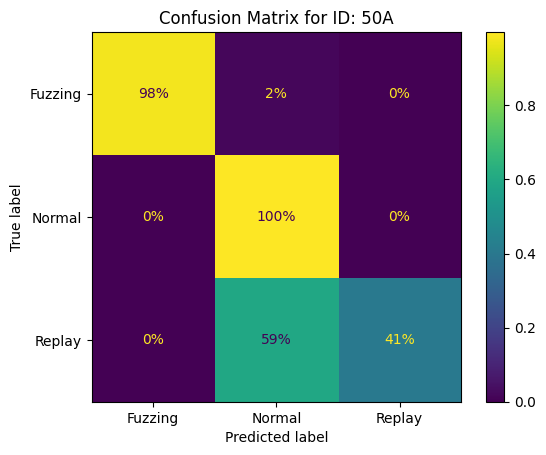

<Figure size 800x600 with 0 Axes>



Result 50A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          50A  0.982182  0.684784  0.665472  0.668249
XGBoost                50A  0.987273  0.899866  0.793753  0.832778


Processing ID: 043
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       972
      Normal       0.99      1.00      1.00       747
      Replay       1.00      0.74      0.85        19

    accuracy                           1.00      1738
   macro avg       1.00      0.91      0.95      1738
weighted avg       1.00      1.00      1.00      1738



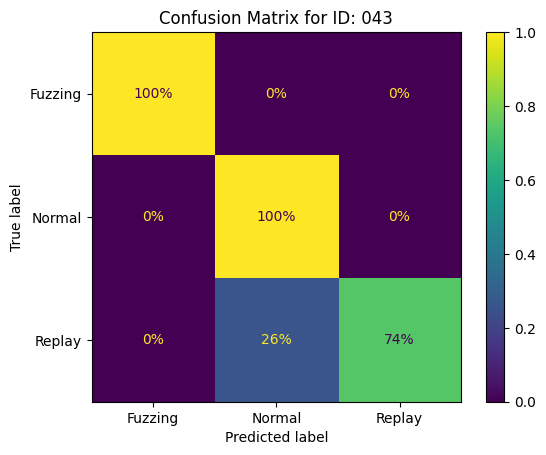

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       972
      Normal       0.98      1.00      0.99       747
      Replay       1.00      0.37      0.54        19

    accuracy                           0.99      1738
   macro avg       0.99      0.79      0.84      1738
weighted avg       0.99      0.99      0.99      1738



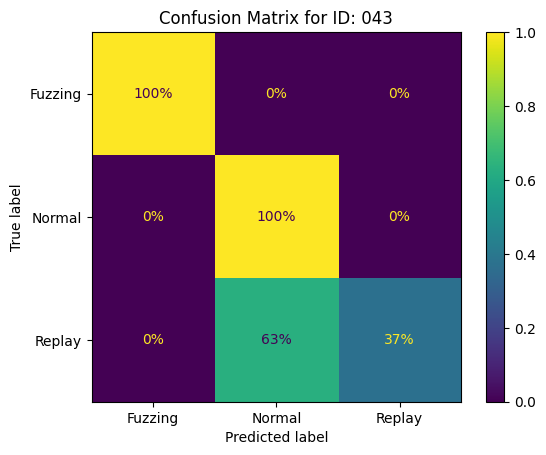

<Figure size 800x600 with 0 Axes>



Result 043 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          043  0.997123  0.997784  0.912281  0.948383
XGBoost                043  0.993096   0.99473  0.789474  0.843498


Processing ID: 52A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       482
      Normal       0.99      1.00      0.99      8543
      Replay       1.00      0.00      0.00       120

    accuracy                           0.99      9145
   macro avg       1.00      0.67      0.66      9145
weighted avg       0.99      0.99      0.98      9145



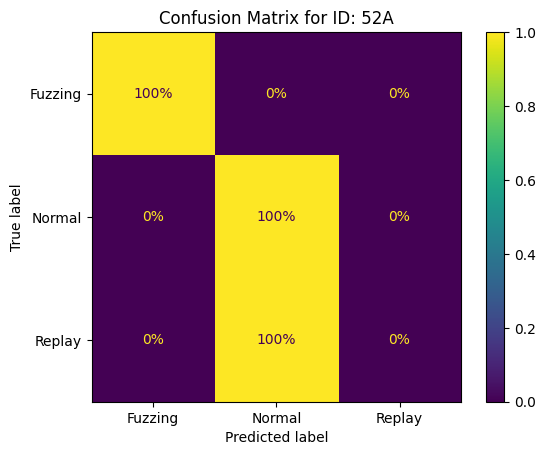

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       482
      Normal       0.99      1.00      0.99      8543
      Replay       0.41      0.16      0.23       120

    accuracy                           0.99      9145
   macro avg       0.80      0.71      0.74      9145
weighted avg       0.98      0.99      0.98      9145



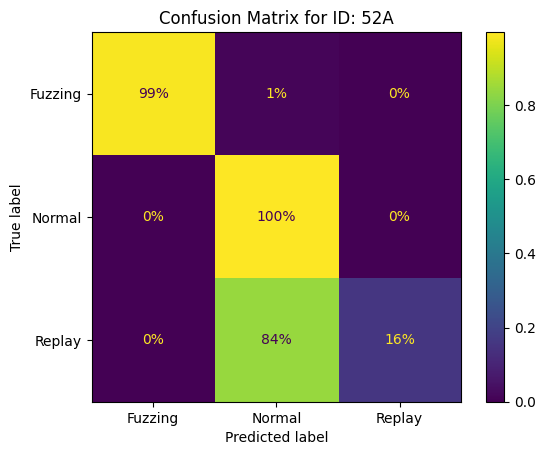

<Figure size 800x600 with 0 Axes>



Result 52A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          52A  0.986878  0.995383  0.666667  0.664342
XGBoost                52A  0.985238  0.800173   0.71355  0.737912


Processing ID: 544
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       513
      Normal       1.00      1.00      1.00      3719
      Replay       0.94      0.92      0.93        79

    accuracy                           1.00      4311
   macro avg       0.98      0.97      0.98      4311
weighted avg       1.00      1.00      1.00      4311



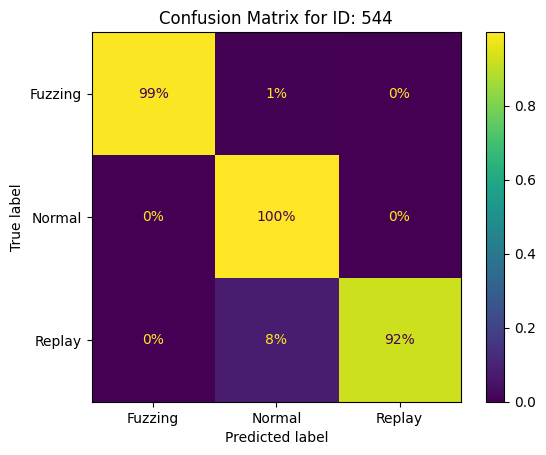

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       513
      Normal       1.00      1.00      1.00      3719
      Replay       0.97      0.94      0.95        79

    accuracy                           1.00      4311
   macro avg       0.99      0.98      0.98      4311
weighted avg       1.00      1.00      1.00      4311



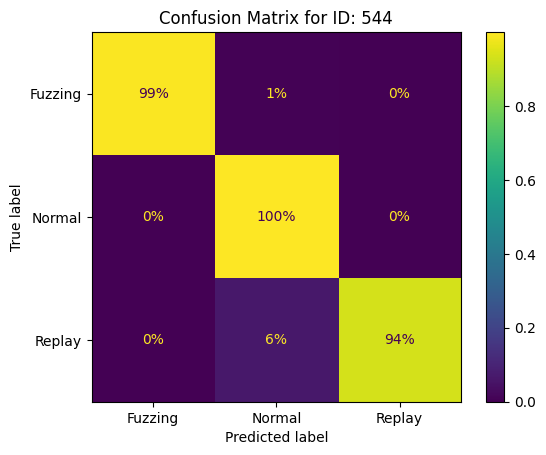

<Figure size 800x600 with 0 Axes>



Result 544 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          544  0.996752  0.977827  0.972286  0.975041
XGBoost                544   0.99768  0.990512  0.976774  0.983521


Processing ID: 559
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       459
      Normal       1.00      1.00      1.00      3718
      Replay       1.00      0.84      0.91        79

    accuracy                           1.00      4256
   macro avg       1.00      0.95      0.97      4256
weighted avg       1.00      1.00      1.00      4256



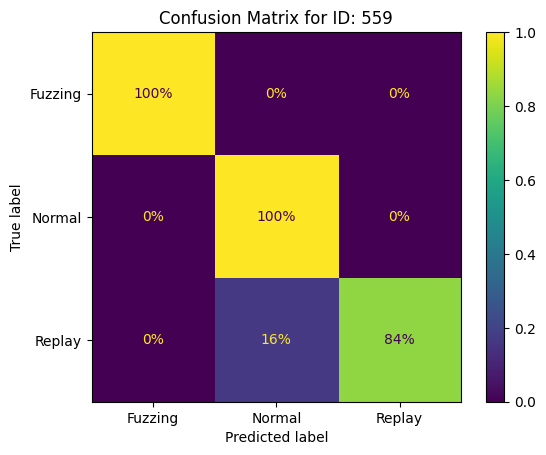

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       459
      Normal       1.00      1.00      1.00      3718
      Replay       0.97      0.92      0.95        79

    accuracy                           1.00      4256
   macro avg       0.99      0.97      0.98      4256
weighted avg       1.00      1.00      1.00      4256



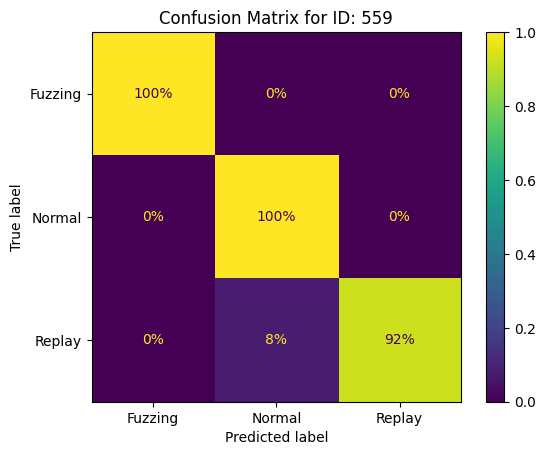

<Figure size 800x600 with 0 Axes>



Result 559 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          559  0.996945  0.998839  0.945148  0.969533
XGBoost                559   0.99812  0.990574  0.974504  0.982326


Processing ID: 410
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       531
      Normal       1.00      1.00      1.00      3726
      Replay       1.00      0.85      0.92        79

    accuracy                           1.00      4336
   macro avg       1.00      0.95      0.97      4336
weighted avg       1.00      1.00      1.00      4336



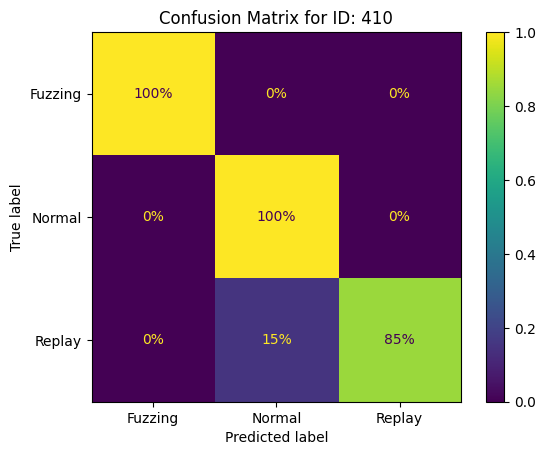

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       531
      Normal       1.00      1.00      1.00      3726
      Replay       1.00      0.91      0.95        79

    accuracy                           1.00      4336
   macro avg       1.00      0.97      0.98      4336
weighted avg       1.00      1.00      1.00      4336



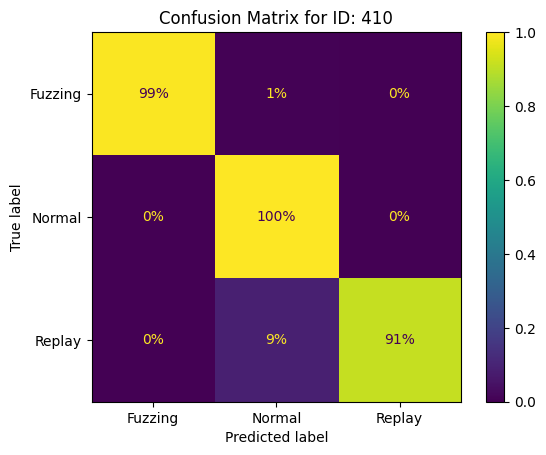

<Figure size 800x600 with 0 Axes>



Result 410 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          410  0.997232   0.99893  0.949367  0.972067
XGBoost                410  0.997463  0.999019  0.967953  0.982796


Processing ID: 07F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       527
      Normal       0.99      1.00      1.00       747
      Replay       1.00      0.69      0.81        16

    accuracy                           1.00      1290
   macro avg       1.00      0.90      0.94      1290
weighted avg       1.00      1.00      1.00      1290



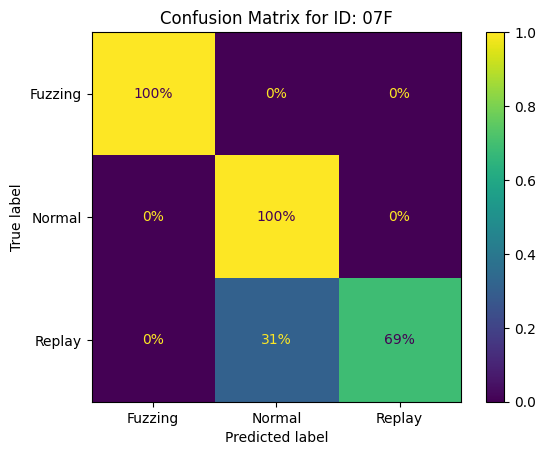

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       527
      Normal       0.99      1.00      1.00       747
      Replay       0.91      0.62      0.74        16

    accuracy                           0.99      1290
   macro avg       0.97      0.87      0.91      1290
weighted avg       0.99      0.99      0.99      1290



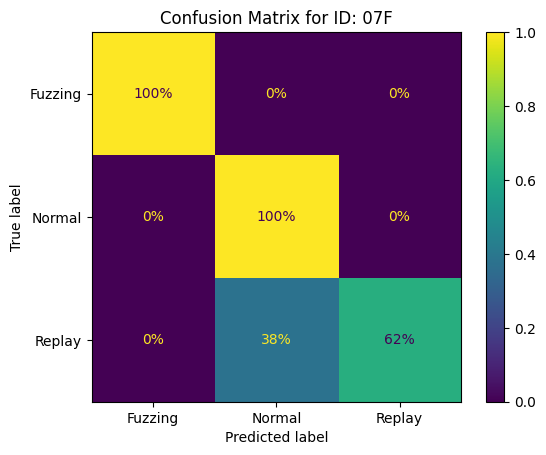

<Figure size 800x600 with 0 Axes>



Result 07F models:

              ProcessingID  Accuracy Precision    Recall F1 Score
Random Forest          07F  0.996124  0.997784  0.895833  0.93716
XGBoost                07F  0.994574  0.967041  0.874367  0.91193


Processing ID: 57F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.97      0.98       518
      Normal       0.96      0.99      0.97       369
      Replay       1.00      0.71      0.83         7

    accuracy                           0.98       894
   macro avg       0.98      0.89      0.93       894
weighted avg       0.98      0.98      0.98       894



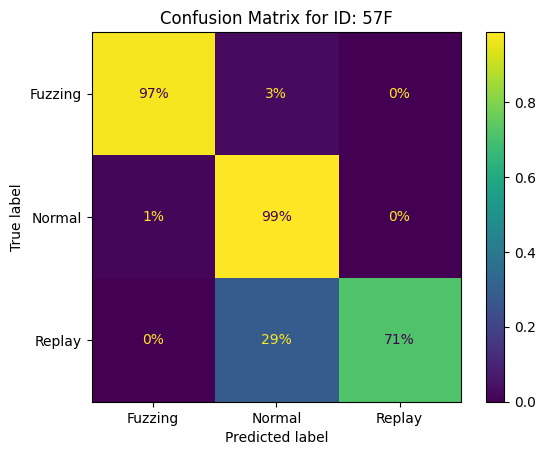

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       518
      Normal       0.99      1.00      1.00       369
      Replay       0.83      0.71      0.77         7

    accuracy                           1.00       894
   macro avg       0.94      0.90      0.92       894
weighted avg       1.00      1.00      1.00       894



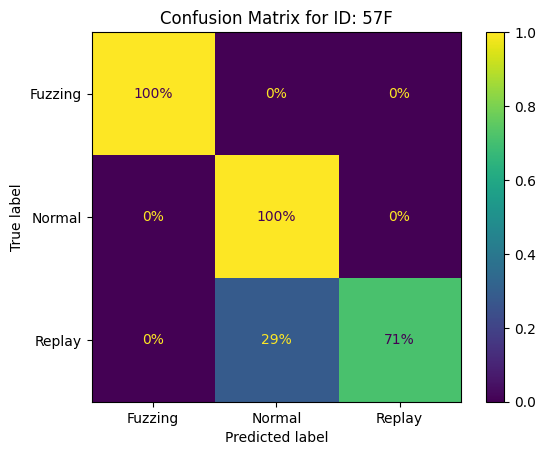

<Figure size 800x600 with 0 Axes>



Result 57F models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          57F   0.97651  0.982691  0.891236  0.928932
XGBoost                57F  0.996644  0.942647  0.904118  0.921854


Processing ID: 5B0
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       1.00      1.00      1.00       744
      Replay       1.00      0.87      0.93        15

    accuracy                           1.00      1256
   macro avg       1.00      0.96      0.98      1256
weighted avg       1.00      1.00      1.00      1256



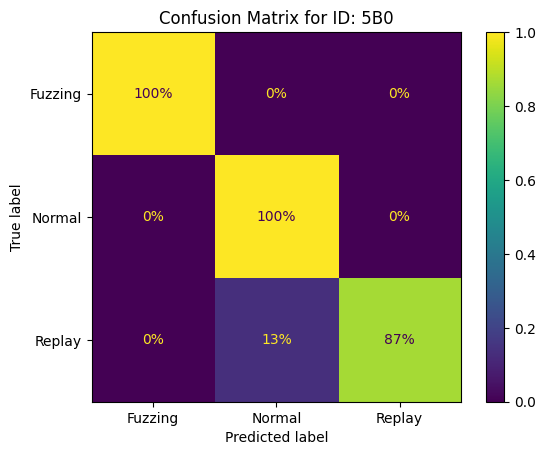

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       497
      Normal       1.00      1.00      1.00       744
      Replay       1.00      1.00      1.00        15

    accuracy                           1.00      1256
   macro avg       1.00      1.00      1.00      1256
weighted avg       1.00      1.00      1.00      1256



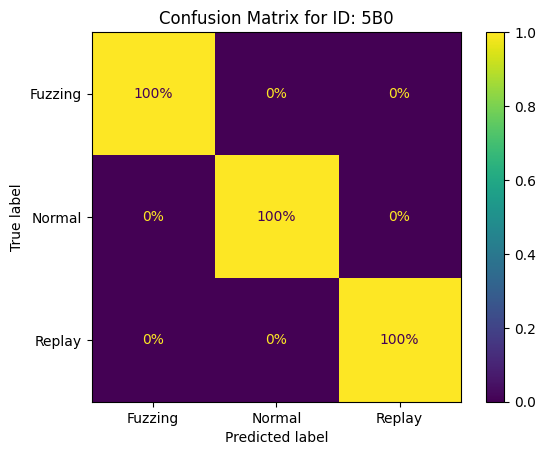

<Figure size 800x600 with 0 Axes>



Result 5B0 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          5B0  0.998408  0.999106  0.955556  0.975743
XGBoost                5B0       1.0       1.0       1.0       1.0




In [ ]:
from sklearn.metrics import precision_recall_fscore_support

evaluation_results={}
df_results = pd.DataFrame()

for data_id in ids:
    print(f"Processing ID: {data_id}")
    y_test, preds, modelAcc, class_labels = id_train_test(dfs_by_id_train, dfs_by_id_test, data_id, models)

    for model_name in models:
        # precision, recall, f1-score 계산
        precision, recall, f1_score, support = precision_recall_fscore_support(y_test, preds[model_name], average='macro', zero_division=1.0)

        # 결과를 딕셔너리에 저장
        evaluation_results[model_name] = {
            'ProcessingID': data_id,
            'Accuracy': modelAcc[model_name],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }

        print(f"{model_name} Classification Report:\n")
        print(classification_report(y_test, preds[model_name], target_names=class_labels, zero_division=1.0))

        # 혼동 행렬 계산 및 시각화
        disp = ConfusionMatrixDisplay.from_predictions(y_test, preds[model_name], display_labels=class_labels, normalize='true', values_format='.0%')

        # 시각화
        plt.title(f'Confusion Matrix for ID: {data_id}')
        #disp.plot(cmap=plt.cm.Blues)
        plt.figure(figsize=(8, 6))
        #cm = confusion_matrix(y_test, y_pred)
        plt.show()
        print("\n" + "="*80 + "\n")

    # 각 아이디별, 모델별 결과 저장
    df_results = pd.concat([df_results, pd.DataFrame(evaluation_results).T])

    # 결과 출력
    print(f'Result {data_id} models:\n')
    print(pd.DataFrame(evaluation_results).T)


    print("\n" + "="*80 + "\n")

### 모든 ID들의 성능의 평균치 계산
- Accuracy, F1-score, Precision의 평균 계산

In [ ]:
df_results

,ProcessingID,Accuracy,Precision,Recall,F1 Score
Random Forest,251,0.997402,0.982844,0.957603,0.969505
XGBoost,251,0.986611,0.894271,0.776035,0.796281
Random Forest,2B0,0.998435,0.995945,0.97772,0.986562
XGBoost,2B0,0.99017,0.991552,0.841947,0.893543
Random Forest,381,0.995964,0.983998,0.946218,0.963902
...,...,...,...,...,...
XGBoost,07F,0.994574,0.967041,0.874367,0.91193
Random Forest,57F,0.97651,0.982691,0.891236,0.928932
XGBoost,57F,0.996644,0.942647,0.904118,0.921854
Random Forest,5B0,0.998408,0.999106,0.955556,0.975743


In [ ]:
performance_IDs = df_results.reset_index().copy()
performance_IDs.rename(columns={'index': 'model'}, inplace=True)
performance_IDs = performance_IDs.round(6)
display(performance_IDs)

output_file = '/content/drive/MyDrive/CAN/submit_filter_data/model_performance_scores_by_id_v2.csv'
performance_IDs.to_csv(output_file, index=False)

,model,ProcessingID,Accuracy,Precision,Recall,F1 Score
0,Random Forest,251,0.997402,0.982844,0.957603,0.969505
1,XGBoost,251,0.986611,0.894271,0.776035,0.796281
2,Random Forest,2B0,0.998435,0.995945,0.97772,0.986562
3,XGBoost,2B0,0.99017,0.991552,0.841947,0.893543
4,Random Forest,381,0.995964,0.983998,0.946218,0.963902
...,...,...,...,...,...,...
101,XGBoost,07F,0.994574,0.967041,0.874367,0.91193
102,Random Forest,57F,0.97651,0.982691,0.891236,0.928932
103,XGBoost,57F,0.996644,0.942647,0.904118,0.921854
104,Random Forest,5B0,0.998408,0.999106,0.955556,0.975743


In [ ]:
# 전체 ID의 평균 성능 지표 계산
performance_IDs_mean = performance_IDs.drop(['ProcessingID'], axis=1).copy()
performance_IDs_mean.groupby('model').mean()

,Accuracy,Precision,Recall,F1 Score
model,,,,
Random Forest,0.979736,0.973073,0.902248,0.919798
XGBoost,0.992403,0.961111,0.877097,0.904647
